# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Нужно определить рыночную стоимость объектов недвижимости. Для этого необходимо провести исследовательский анализ данных и установить параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

### Изучение общей информации

In [2]:
pip install -U missingno -q


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [55]:
# Импортируем необходимые библиотеки

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
pd.options.display.max_columns=None
%matplotlib inline

import os
import requests
from typing import List, Literal, Optional

Описание данных
- airports_nearest — расстояние до ближайшего аэропорта в метрах (м)
- balcony — число балконов
- ceiling_height — высота потолков (м)
- cityCenters_nearest — расстояние до центра города (м)
- days_exposition — сколько дней было размещено объявление (от публикации до снятия)
- first_day_exposition — дата публикации
- floor — этаж
- floors_total — всего этажей в доме
- is_apartment — апартаменты (булев тип)
- kitchen_area — площадь кухни в квадратных метрах (м²)
- last_price — цена на момент снятия с публикации
- living_area — жилая площадь в квадратных метрах (м²)
- locality_name — название населённого пункта
- open_plan — свободная планировка (булев тип)
- parks_around3000 — число парков в радиусе 3 км
- parks_nearest — расстояние до ближайшего парка (м)
- ponds_around3000 — число водоёмов в радиусе 3 км
- ponds_nearest — расстояние до ближайшего водоёма (м)
- rooms — число комнат
- studio — квартира-студия (булев тип)
- total_area — общая площадь квартиры в квадратных метрах (м²)
- total_images — число фотографий квартиры в объявлении

In [6]:
# Загрузим файлы

base_url = "https://huggingface.co/datasets/onejetpilot/real_estate/resolve/main/"

files = [
    ("real_estate_data.csv", "real_estate_data")
]

for filename, local_path in files:
    if not os.path.exists(local_path):
        print(f"Файл {filename} не найден — начинаю скачивание...")

        file_url = base_url + filename
        response = requests.get(file_url, stream=True)

        if response.status_code == 200:
            with open(local_path, "wb") as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
            print(f"Файл успешно скачан: {local_path}")
        else:
            print(f"Ошибка при скачивании {filename}: {response.status_code}")
    else:
        print(f"Файл {filename} уже есть локально — загрузка пропущена")


data = pd.read_csv("real_estate_data", sep='\t')

print("Все файлы успешно загружены в DataFrame")

Файл real_estate_data.csv не найден — начинаю скачивание...
Файл успешно скачан: real_estate_data
Все файлы успешно загружены в DataFrame


In [7]:
# Напечатаем первые 5 строк датасета

data.head()

total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0       108.0  2019-03-07T00:00:00      3   
1             7   3350000.0        40.4  2018-12-04T00:00:00      1   
2            10   5196000.0        56.0  2015-08-20T00:00:00      2   
3             0  64900000.0       159.0  2015-07-24T00:00:00      3   
4             2  10000000.0       100.0  2018-06-19T00:00:00      2   

   ceiling_height  floors_total  living_area  floor is_apartment  studio  \
0            2.70          16.0         51.0      8          NaN   False   
1             NaN          11.0         18.6      1          NaN   False   
2             NaN           5.0         34.3      4          NaN   False   
3             NaN          14.0          NaN      9          NaN   False   
4            3.03          14.0         32.0     13          NaN   False   

   open_plan  kitchen_area  balcony    locality_name  airports_nearest  \
0      False          25.0      NaN  Санкт-Петербург           18863.0   
1      False          11.0      2.0   посёлок Шушары           12817.0   
2      False           8.3      0.0  Санкт-Петербург           21741.0   
3      False           NaN      0.0  Санкт-Петербург           28098.0   
4      False          41.0      NaN  Санкт-Петербург           31856.0   

   cityCenters_nearest  parks_around3000  parks_nearest  ponds_around3000  \
0              16028.0               1.0          482.0               2.0   
1              18603.0               0.0            NaN               0.0   
2              13933.0               1.0           90.0               2.0   
3               6800.0               2.0           84.0               3.0   
4               8098.0               2.0          112.0               1.0   

   ponds_nearest  days_exposition  
0          755.0              NaN  
1            NaN             81.0  
2          574.0            558.0  
3          234.0            424.0  
4           48.0            121.0

In [8]:
# Посмотрим информацию о датасете

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [9]:
data.describe(include='all')

total_images    last_price    total_area first_day_exposition  \
count   23699.000000  2.369900e+04  23699.000000                23699   
unique           NaN           NaN           NaN                 1491   
top              NaN           NaN           NaN  2018-02-01T00:00:00   
freq             NaN           NaN           NaN                  368   
mean        9.858475  6.541549e+06     60.348651                  NaN   
std         5.682529  1.088701e+07     35.654083                  NaN   
min         0.000000  1.219000e+04     12.000000                  NaN   
25%         6.000000  3.400000e+06     40.000000                  NaN   
50%         9.000000  4.650000e+06     52.000000                  NaN   
75%        14.000000  6.800000e+06     69.900000                  NaN   
max        50.000000  7.630000e+08    900.000000                  NaN   

               rooms  ceiling_height  floors_total   living_area  \
count   23699.000000    14504.000000  23613.000000  21796.000000   
unique           NaN             NaN           NaN           NaN   
top              NaN             NaN           NaN           NaN   
freq             NaN             NaN           NaN           NaN   
mean        2.070636        2.771499     10.673824     34.457852   
std         1.078405        1.261056      6.597173     22.030445   
min         0.000000        1.000000      1.000000      2.000000   
25%         1.000000        2.520000      5.000000     18.600000   
50%         2.000000        2.650000      9.000000     30.000000   
75%         3.000000        2.800000     16.000000     42.300000   
max        19.000000      100.000000     60.000000    409.700000   

               floor is_apartment studio open_plan  kitchen_area  \
count   23699.000000         2775  23699     23699  21421.000000   
unique           NaN            2      2         2           NaN   
top              NaN        False  False     False           NaN   
freq             NaN         2725  23550     23632           NaN   
mean        5.892358          NaN    NaN       NaN     10.569807   
std         4.885249          NaN    NaN       NaN      5.905438   
min         1.000000          NaN    NaN       NaN      1.300000   
25%         2.000000          NaN    NaN       NaN      7.000000   
50%         4.000000          NaN    NaN       NaN      9.100000   
75%         8.000000          NaN    NaN       NaN     12.000000   
max        33.000000          NaN    NaN       NaN    112.000000   

             balcony    locality_name  airports_nearest  cityCenters_nearest  \
count   12180.000000            23650      18157.000000         18180.000000   
unique           NaN              364               NaN                  NaN   
top              NaN  Санкт-Петербург               NaN                  NaN   
freq             NaN            15721               NaN                  NaN   
mean        1.150082              NaN      28793.672193         14191.277833   
std         1.071300              NaN      12630.880622          8608.386210   
min         0.000000              NaN          0.000000           181.000000   
25%         0.000000              NaN      18585.000000          9238.000000   
50%         1.000000              NaN      26726.000000         13098.500000   
75%         2.000000              NaN      37273.000000         16293.000000   
max         5.000000              NaN      84869.000000         65968.000000   

        parks_around3000  parks_nearest  ponds_around3000  ponds_nearest  \
count       18181.000000    8079.000000      18181.000000    9110.000000   
unique               NaN            NaN               NaN            NaN   
top                  NaN            NaN               NaN            NaN   
freq                 NaN            NaN               NaN            NaN   
mean            0.611408     490.804555          0.770255     517.980900   
std             0.802074     342.317995          0.938346     277.720643   
min 

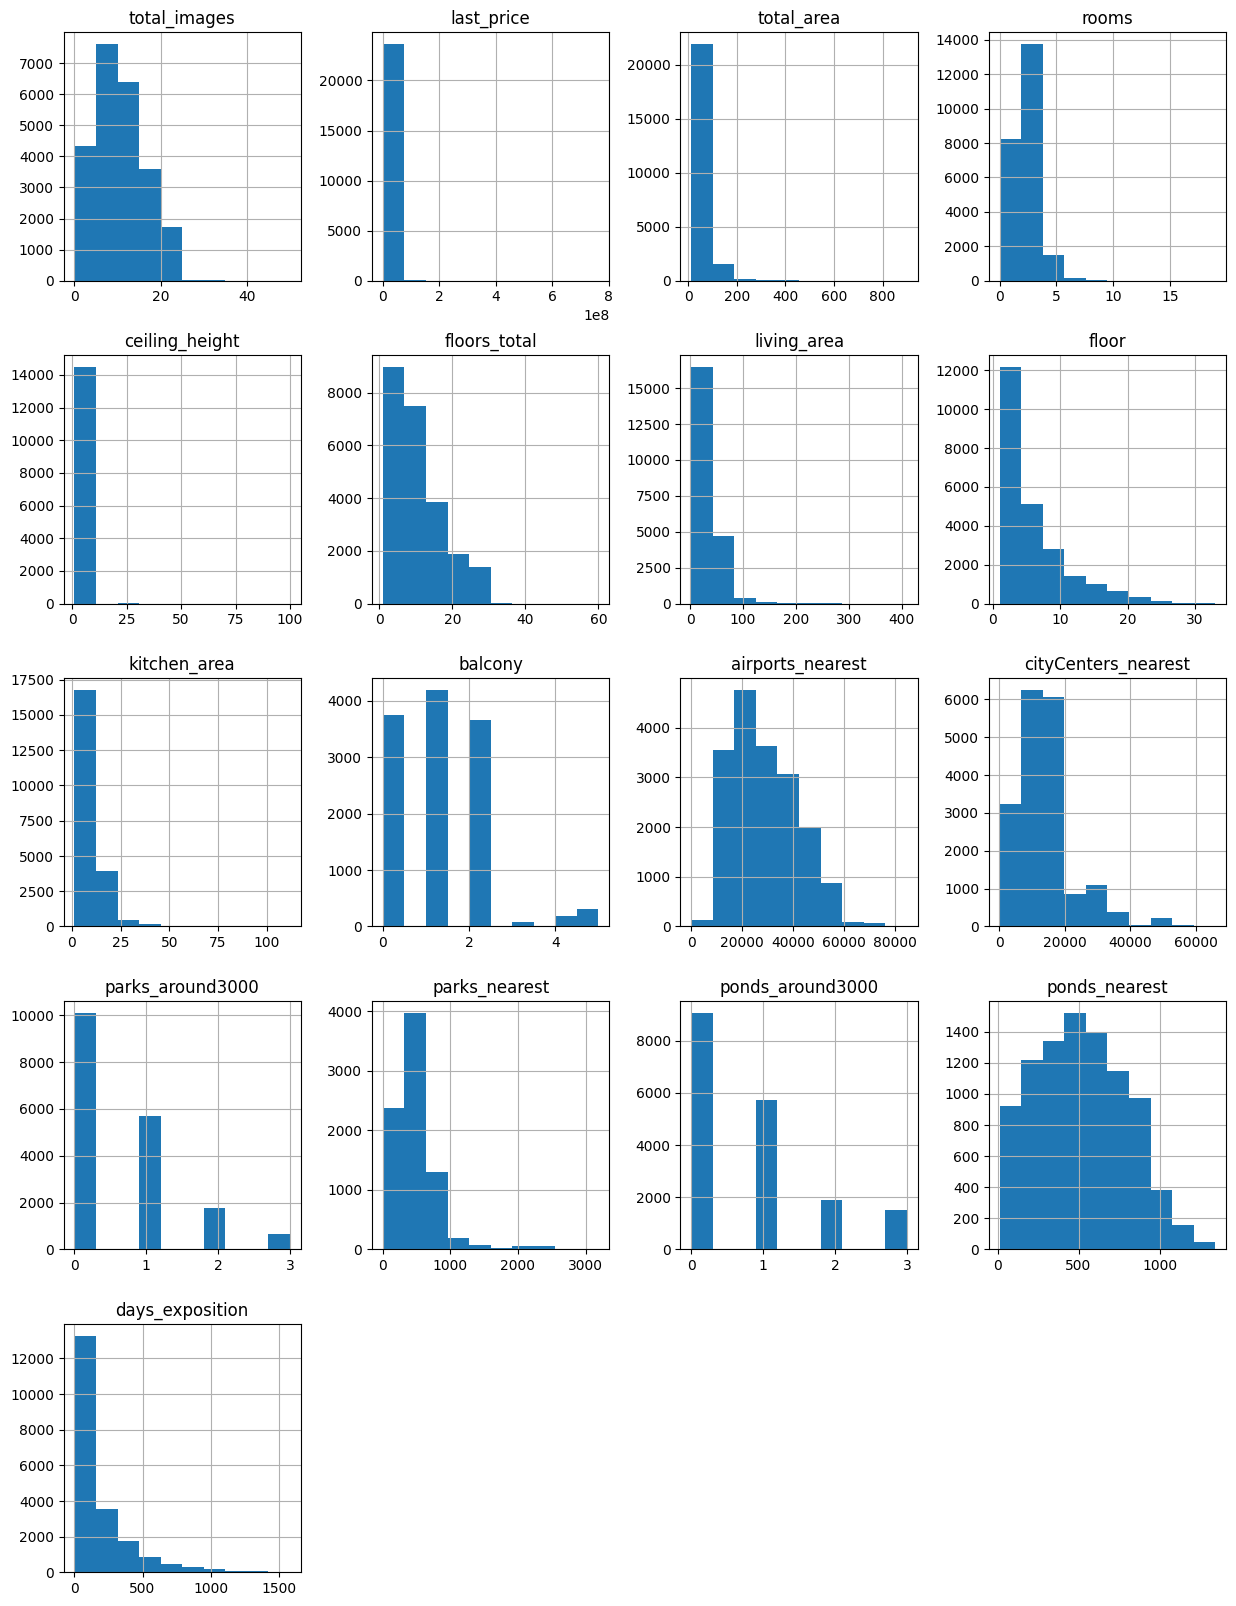

In [10]:
# Построим гистограммы для всех числовых столбцов

data.hist(figsize=(15, 20))
plt.show()

В данных присутствуют пропуски и выбросы, типы данных не соответствуют ожидаемым. Необходимо выполнить предобработку данных перед началом анализа.

### Предобработка данных

#### Приведение названий столбцов к нижнему регистру

In [11]:
# Переименуем столбец cityCenters_nearest

data = data.rename(columns = {'cityCenters_nearest': 'city_centers_nearest'}) 

#### Заполнение пропущенных значений

In [12]:
# Найдем столбцы с пропущенными значениями

data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
city_centers_nearest     5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

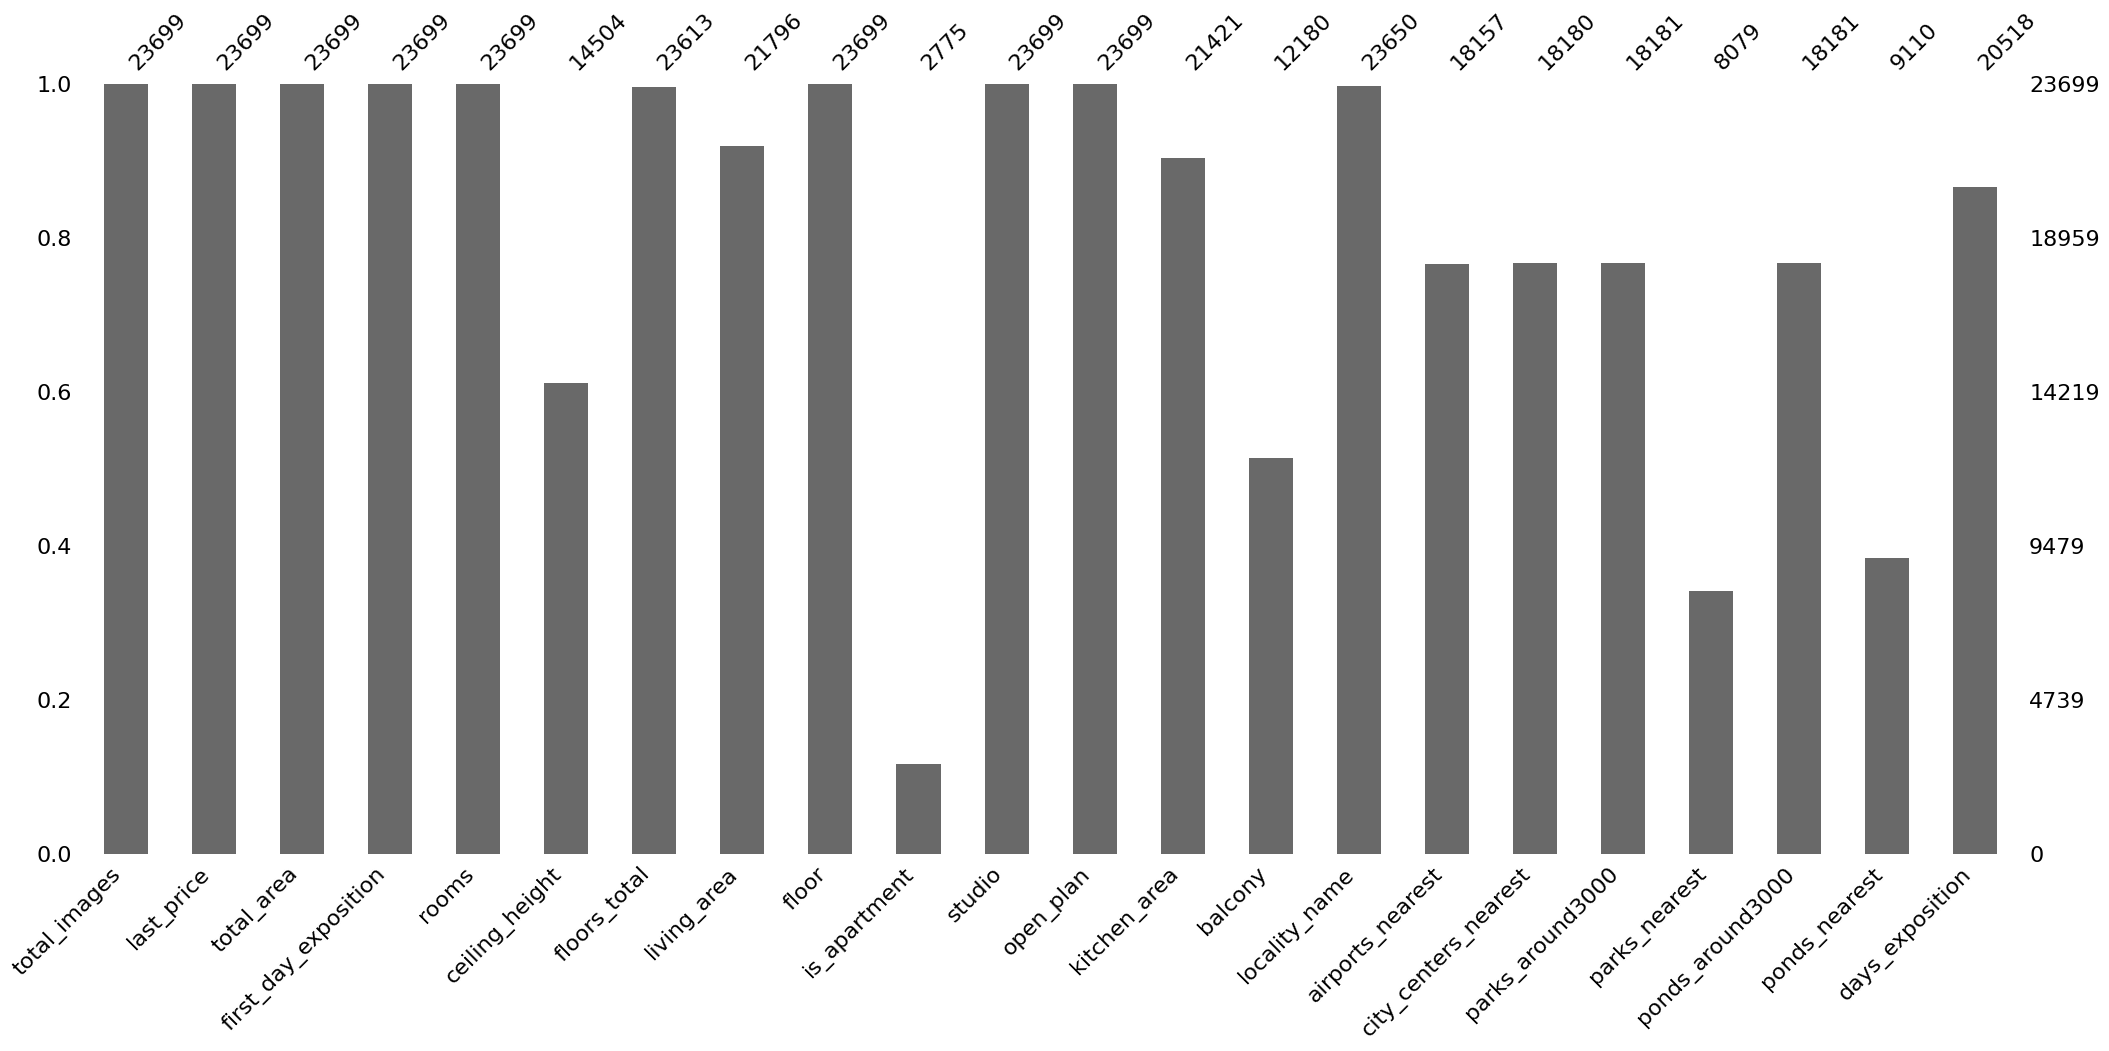

In [13]:
# Визуализируем пропущенные значения

msno.bar(data)
plt.show()

Заполним пропущенные значения следующим образом:

- ceiling_height - высоту потолка заполним медианным значением. Пропусков большое количество, думаю это вызвано тем, что люди не помнят какой высоты потолок у них в квратире.
- floors_total - заполним значением из колонки floor + 1, чтобы при заполнении медианой или средним значением не возникла ситуация когда этажность дома меньше этажа на котором находится квартира. Добавим +1 к этажности дома чтобы квартира не была на последнем этаже, думаю то на каком этаже квартира (первый или последний) значительно влияет на цену квартиры. Пропусков мало, возможно просто забыли написать.
- living_area - жилую площадь заполним медианным значением, думаю пропуски появились также из-за незнания.
- is_apartment - апартаменты или нет, будем считать если человек не заполнил данные значит это не апартаменты. Посколько это буллев тип заполним пропуски значением False.
- kitchen_area - площадь кухни заполним медианным значением, пропусков примерно столько же сколько в жилой площади. Можно предположить, что не все знают площадь кухни в квартире.
- balcony - количество балконов, думаю не заполняли балконы т.к. в квартире их нет. Заполним пропущенные значения нулем.
- locality_name - заполним значением значением Другой, т.к. пропусков не большое количесво.
- airports_nearest - ближайщие аэропорты заполним медианными значениями расстояний до аэропорта по каждой локации. Пропуски могли произойти из-за ошибок. Те пропуски которые не получится заполнить первым способом, заполним медианой.
- city_centers_nearest - также можем посчитать медианное расстояние до центра в каждой локации и заполнить этими значениями пропуски в зависимости от локации. Пропуски также думаю произошли по ошибке. Также заполним медианой оставшиеся незаполненные значения.
- parks_around3000 - возможно значения пропущены из-за того, что этих данных не было в геосервисах. Заполним пропущенные значения нулями.
- parks_nearest - если parks_around3000 в пропущенных значениях больше или равно 1 заполним пропуски средним расстоянием до парков до 3000 м, если parks_around3000 равно нулю, заполним средними значениями от 3000 м. Если таких значений не будет - заполним пропуски нулями.
- ponds_around3000 - заполним аналогично parks_around3000
- ponds_nearest - заполним аналогично parks_nearest
- days_exposition — возможно обьявление еще не снято, поэтому данных о времени между публикацией и снятием еще нет. Думаю мы можем заполнить эти значения медианой.


In [14]:
# Заменяем данные в колонке floors_total на floor + 1

data['floors_total'] = data['floors_total'].fillna(value=(data['floor']+1))

In [15]:
# Заменим пропуски в колонке living_area на среднее значение в зависимости от числа комнат в квартире

for d in data['rooms'].unique():
    data.loc[(data['rooms'] == d) & (data['living_area'].isna()), 'living_area'] = \
    data.loc[(data['rooms'] == d), 'living_area'].mean()

In [16]:
# Заменим пропуски в колонке living_area на False

data['is_apartment'] = data['is_apartment'].fillna('False')

In [17]:
# Найдем самое популярное значение локаций

pd.pivot_table(data, index=['locality_name'], values=['kitchen_area'], aggfunc='count').sort_values(by='kitchen_area', ascending=False).head()

kitchen_area
locality_name                
Санкт-Петербург         14342
посёлок Мурино            422
посёлок Шушары            398
Всеволожск                357
Пушкин                    338

In [18]:
# Заполним пропуски в колонке locality_name значением Другой

data['locality_name'] = data['locality_name'].fillna('Другой')

In [19]:
# Заполним пропуски в колонке airports_nearest медианным значением расстояний от каждой локации до аэропорта и 
# в колонке cityCenters_nearest медианным значением расстояний от каждой локации до центра

for d in data['locality_name'].unique():
    data.loc[(data['locality_name'] == d) & (data['locality_name'].isna()), 'airports_nearest'] = \
    data.loc[(data['locality_name'] == d), 'airports_nearest'].mean()
    data.loc[(data['locality_name'] == d) & (data['city_centers_nearest'].isna()), 'city_centers_nearest'] = \
    data.loc[(data['locality_name'] == d), 'city_centers_nearest'].mean()

In [20]:
# Те населенные пункты по которым совсем нет данных по удалению от аэропортов и центров заполним медианным значением

data['airports_nearest'] = data['airports_nearest'].fillna(value=data['airports_nearest'].median())
data['city_centers_nearest'] = data['city_centers_nearest'].fillna(value=data['city_centers_nearest'].median())

In [21]:
# Проверим есть ли пропущенные значения parks_nearest в расстояних до парков с заполненными parks_nearest > 0

data.loc[(data['parks_around3000'] > 0) & (data['parks_nearest'].isna())]

Empty DataFrame
Columns: [total_images, last_price, total_area, first_day_exposition, rooms, ceiling_height, floors_total, living_area, floor, is_apartment, studio, open_plan, kitchen_area, balcony, locality_name, airports_nearest, city_centers_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest, days_exposition]
Index: []

In [22]:
# Заполним пропуски в колонках parks_around3000 и parks_around3000 нулями
# Заменяем данные в колонке balcony на 0
# Заполним значения до ближайших парков также нулями. Возможно парков в городе просто нет.
# Заполним значения до ближайших прудов также нулями. Возможно прудов в городе тоже просто нет.

for i in ['parks_nearest', 'parks_around3000', 'ponds_around3000', 'balcony', 'ponds_nearest', 'days_exposition']:
    data[i] = data[i].fillna(0)

In [23]:
# Проверим есть ли пропущенные значения ponds_nearest в расстояних до парков с заполненными ponds_nearest > 0

data.loc[(data['ponds_around3000'] > 0) & (data['ponds_nearest'].isna())]

Empty DataFrame
Columns: [total_images, last_price, total_area, first_day_exposition, rooms, ceiling_height, floors_total, living_area, floor, is_apartment, studio, open_plan, kitchen_area, balcony, locality_name, airports_nearest, city_centers_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest, days_exposition]
Index: []

In [24]:
# Значения в колонке days_exposition заполним медианой

data['days_exposition'] = data['days_exposition'].fillna(0)

In [25]:
# Проверим что пропущенных значений больше не осталось

data.isna().sum()

total_images               0
last_price                 0
total_area                 0
first_day_exposition       0
rooms                      0
ceiling_height          9195
floors_total               0
living_area                0
floor                      0
is_apartment               0
studio                     0
open_plan                  0
kitchen_area            2278
balcony                    0
locality_name              0
airports_nearest           0
city_centers_nearest       0
parks_around3000           0
parks_nearest              0
ponds_around3000           0
ponds_nearest              0
days_exposition            0
dtype: int64

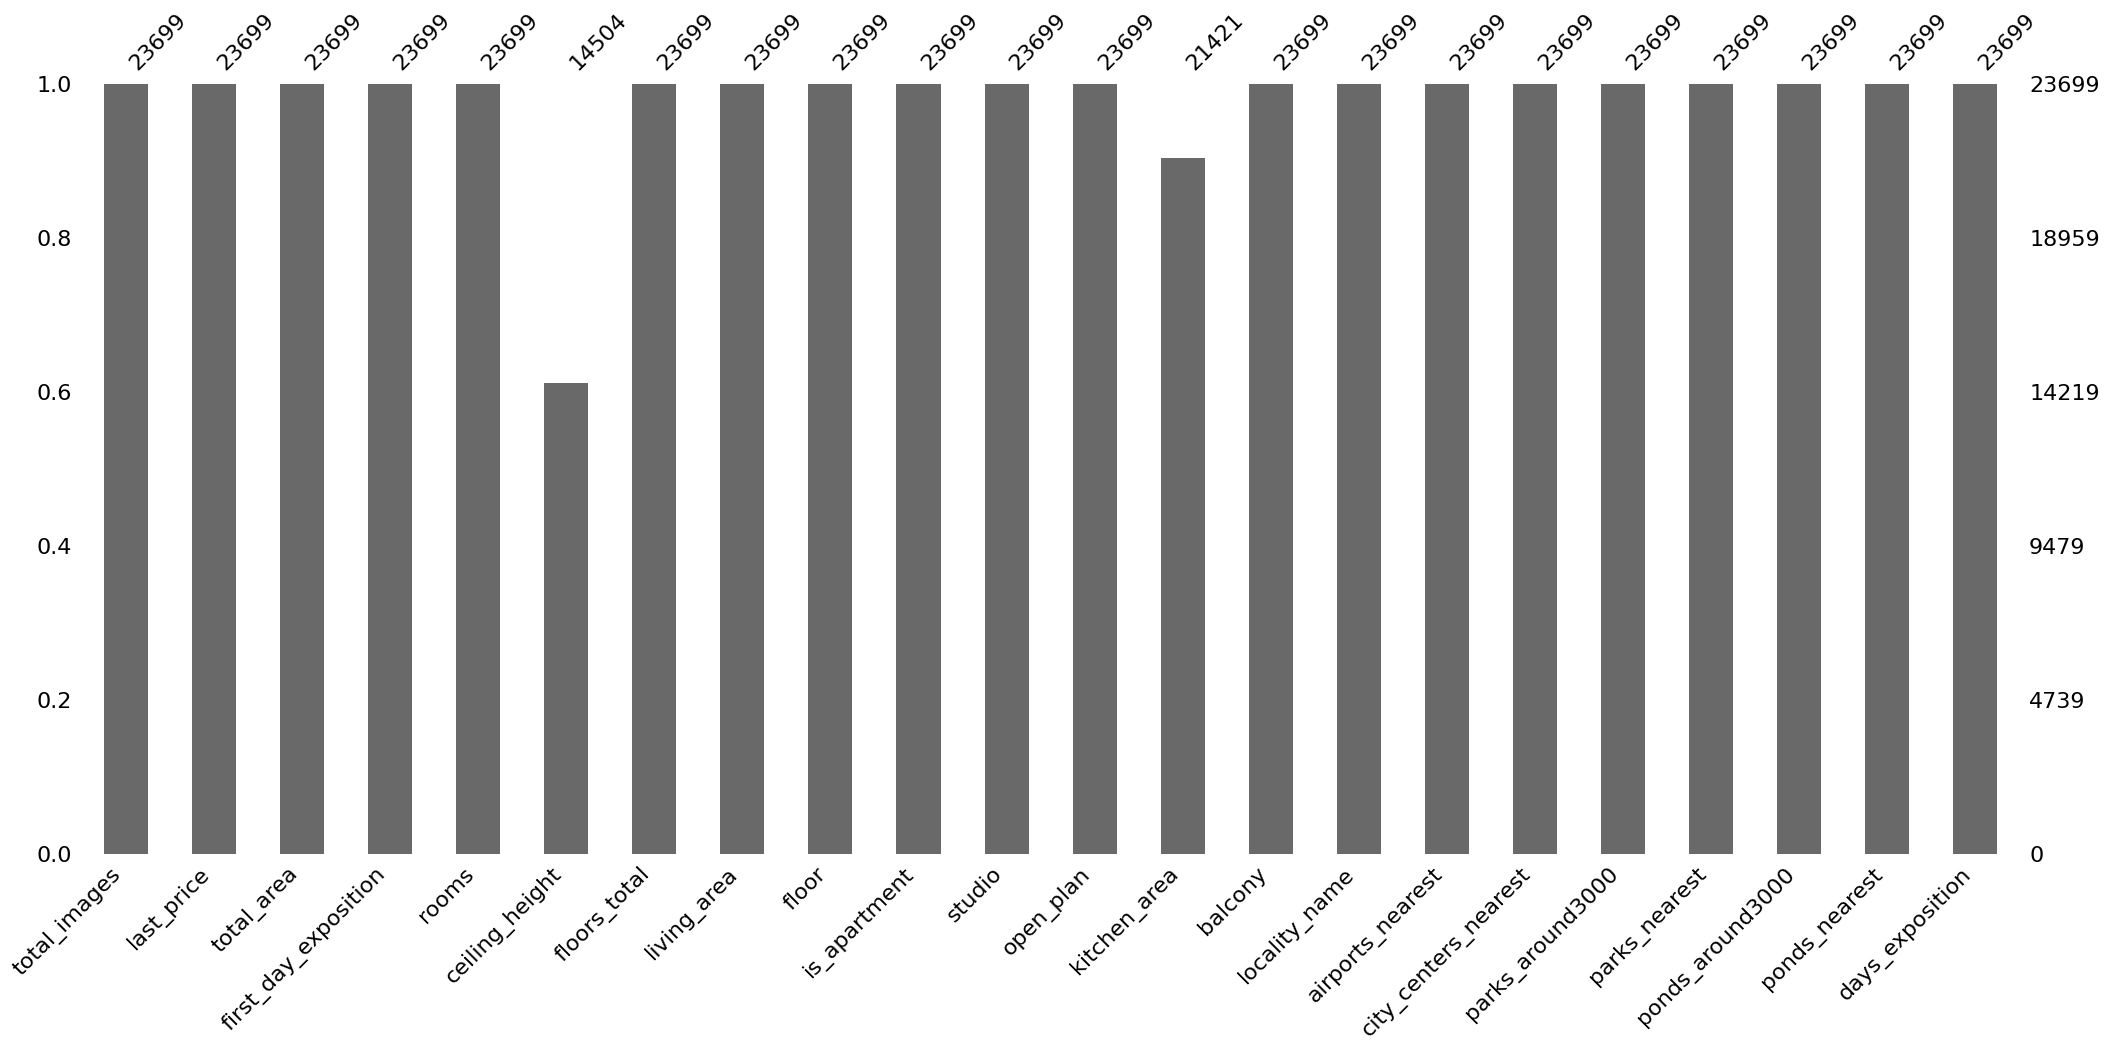

In [26]:
# Визуализируем пропущенные значения

msno.bar(data)
plt.show()

Пропусков больше нет кроме тех где мы заменяем пропущенные значения на медину. Эти замены перенес в тот раздел где мы удалем выбросы

#### Преобразование типов данных

Преобразуем типы данных исходя из следующей логики:
- total_images          - может быть только целыми значениями, изменим на int
- last_price            - оставим float, может быть не целым числом
- total_area            - оставим float, может быть не целым числом
- first_day_exposition  - изменим на datetime, т.к. это дата
- rooms                 - может быть только целыми значениями, изменим на int 
- ceiling_height        - оставим float, может быть не целым числом
- floors_total          - может быть только целыми значениями, изменим на int
- living_area           - оставим float, может быть не целым числом
- floor                 - оставим int, может быть только целым
- is_apartment          - изменим на bool, может принимать только 2 значения
- studio                - оставим bool, может принимать только 2 значения
- open_plan             - оставим bool, может принимать только 2 значения
- kitchen_area          - оставим float, может быть не целым числом
- balcony               - может быть только целыми значениями, изменим на int
- locality_name         - оставим object, название населенного пункта
- airports_nearest      - оставим float, может быть не целым числом
- cityCenters_nearest   - оставим float, может быть не целым числом
- parks_around3000      - может быть только целыми значениями, изменим на int
- parks_nearest         - оставим float, может быть не целым числом
- ponds_around3000      - может быть только целыми значениями, изменим на int
- ponds_nearest         - оставим float, может быть не целым числом
- days_exposition       - может быть только целыми значениями, изменим на int

In [27]:
# Преобразуем числовые и булевы типы данных

data = data.astype({
    'total_images': 'int32',
    'rooms': 'int32',
    'floors_total': 'int32',
    'is_apartment': 'bool',
    'balcony': 'int32',
    'parks_around3000': 'int32',
    'ponds_around3000': 'int32',
    'days_exposition': 'int32'
})

In [28]:
# Преобразуем колонку с датой размещения объявления first_day_exposition в формат даты

data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

In [29]:
# Проверим типы данных после преобразования

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int32         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int32         
 5   ceiling_height        14504 non-null  float64       
 6   floors_total          23699 non-null  int32         
 7   living_area           23699 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          21421 non-null  float64       
 13  balcony         

#### Устранение неявных дубликатов

In [30]:
# Преобразуем строки с названиями в списки

data['locality_name'] = data['locality_name'].str.split(' ')

In [33]:
def town_del(row: List[str]) -> str:
    """
    Удаляет из списка слов названия типов населённых пунктов
    (например: 'посёлок', 'деревня', 'село', 'городской' и т.п.)
    и возвращает оставшиеся слова в виде строки.

    Параметры
    ---------
    row : List[str]
        Список слов (обычно результат разбиения текста на токены),
        из которого нужно удалить определённые слова.

    Возвращает
    ----------
    str
        Строка, составленная из оставшихся слов после удаления нежелательных.
    """

    town = [
        'посёлок',
        'городской',
        'поселок',
        'садовое',
        'товарищество',
        'городского',
        'типа',
        'деревня',
        'село',
        'садоводческое',
        'имени',
        'станции',
        'некоммерческое',
        'железнодорожной',
        'при',
        'коттеджный'
    ]

    filtered = [word for word in row if word not in town]

    return ' '.join(filtered)

In [34]:
# Применим нашу функцию к колонке locality_name

data['locality_name'] = data['locality_name'].apply(town_del)

In [35]:
# Проверим, что все получилось

data['locality_name'].unique()

array(['Санкт-Петербург', 'Шушары', 'Янино-1', 'Парголово', 'Мурино',
       'Ломоносов', 'Сертолово', 'Петергоф', 'Пушкин', 'Кудрово',
       'Коммунар', 'Колпино', 'Красный Бор', 'Гатчина', 'Фёдоровское',
       'Выборг', 'Кронштадт', 'Кировск', 'Новое Девяткино',
       'Металлострой', 'Лебяжье', 'Сиверский', 'Молодцово',
       'Кузьмоловский', 'Новая Ропша', 'Павловск', 'Пикколово',
       'Всеволожск', 'Волхов', 'Кингисепп', 'Приозерск', 'Сестрорецк',
       'Куттузи', 'Аннино', 'Ефимовский', 'Плодовое', 'Заклинье',
       'Торковичи', 'Первомайское', 'Красное Село', 'Понтонный',
       'Сясьстрой', 'Старая', 'Лесколово', 'Новый Свет', 'Сланцы',
       'Путилово', 'Ивангород', 'Шлиссельбург', 'Никольское',
       'Зеленогорск', 'Сосновый Бор', 'Оржицы', 'Кальтино', 'Романовка',
       'Бугры', 'Рощино', 'Кириши', 'Луга', 'Волосово', 'Отрадное',
       'Павлово', 'Оредеж', 'Копорье', 'Молодёжное', 'Тихвин', 'Победа',
       'Нурма', 'Синявино', 'Тосно', 'Стрельна', 'Бокситогорск',

Мы избавились от пропущенных значений в параметрах квартир, устранили неявные дубликаты. Можно отметить, что пропущенные значения не всегда появляются из-за отсутсвия данных, иногда это происходит из-за того что люди не заполняют значения сознательно - например как это случилось с колонкой с количеством балконов или колонкой являтся ли объект апартаментами. 

### Новые признаки

In [36]:
# Создадим столбец price_m с ценой за 1 кв. м

data['price_m'] = round(data['last_price']/(data['total_area']), 2)

In [37]:
# Создадим столбец week_day с днем недели размещения объявления

data['week_day'] = pd.DatetimeIndex(data['first_day_exposition']).weekday

In [38]:
# Создадим столбец month с днем недели размещения объявления

data['month'] = pd.DatetimeIndex(data['first_day_exposition']).month

In [39]:
# Создадим столбец year с днем недели размещения объявления 

data['year'] = pd.DatetimeIndex(data['first_day_exposition']).year

In [44]:
def floor_type(row: pd.Series) -> Literal['первый', 'последний', 'другой']:
    """
    Определяет тип этажа: первый, последний или промежуточный.

    Параметры
    ---------
    row : pd.Series
        Строка DataFrame, содержащая по крайней мере два поля:
        - 'floor' : int — этаж квартиры
        - 'floors_total' : int — общее количество этажей в здании

    Возвращает
    ----------
    Literal['первый', 'последний', 'другой']
        Тип этажа:
        - 'первый'     — если этаж равен 1
        - 'последний'  — если этаж равен общему количеству этажей
        - 'другой'     — все остальные случаи
    """

    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'

In [45]:
# Создадим новую колонку floor_type с типами этажа квартиры

data['floor_type'] = data.apply(floor_type, axis=1)

In [ ]:
# Создадим колонку с расстоянием до центра города в км city_centers_nearest_km

data['city_centers_nearest_km'] = round(data['city_centers_nearest'] / 1000).astype('int')

In [ ]:
# Проверим все ли созданные колонки на месте

data.head()

total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0       108.0           2019-03-07      3   
1             7   3350000.0        40.4           2018-12-04      1   
2            10   5196000.0        56.0           2015-08-20      2   
3             0  64900000.0       159.0           2015-07-24      3   
4             2  10000000.0       100.0           2018-06-19      2   

   ceiling_height  floors_total  living_area  floor  is_apartment  studio  \
0            2.70            16    51.000000      8          True   False   
1             NaN            11    18.600000      1          True   False   
2             NaN             5    34.300000      4          True   False   
3             NaN            14    47.387941      9          True   False   
4            3.03            14    32.000000     13          True   False   

   open_plan  kitchen_area  balcony    locality_name  airports_nearest  \
0      False          25.0        0  Санкт-Петербург           18863.0   
1      False          11.0        2           Шушары           12817.0   
2      False           8.3        0  Санкт-Петербург           21741.0   
3      False           NaN        0  Санкт-Петербург           28098.0   
4      False          41.0        0  Санкт-Петербург           31856.0   

   city_centers_nearest  parks_around3000  parks_nearest  ponds_around3000  \
0               16028.0                 1          482.0                 2   
1               18603.0                 0            0.0                 0   
2               13933.0                 1           90.0                 2   
3                6800.0                 2           84.0                 3   
4                8098.0                 2          112.0                 1   

   ponds_nearest  days_exposition    price_m  week_day  month  year  \
0          755.0                0  120370.37         3      3  2019   
1            0.0               81   82920.79         1     12  2018   
2          574.0              558   92785.71         3      8  2015   
3          234.0              424  408176.10         4      7  2015   
4           48.0              121  100000.00         1      6  2018   

  floor_type  city_centers_nearest_km  
0     другой                       16  
1     первый                       19  
2     другой                       14  
3     другой                        7  
4     другой                        8

### Исследовательский анализ данных

#### Изучение параметров объектов

In [56]:
def num_diag(
    data: pd.DataFrame,
    x: str,
    xlabel: str,
    ylabel: str,
    hue: Optional[str] = None
) -> None:
    """
    Визуализирует распределение числового признака с помощью гистограммы и boxplot

    Параметры
    ----------
    data : pandas.DataFrame
        Таблица данных, содержащая признак

    x : str
        Название числового признака, по которому строятся графики.

    xlabel : str
        Подпись оси X для графиков

    ylabel : str
        Подпись оси Y для графиков.=

    hue : str, optional
        Название категориального признака для разделения данных по цветам на гистограмме

    Возвращает
    ----------
    None
        Функция строит графики
    """


    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    sns.histplot(
        data=data,
        x=x,
        hue=hue,
        ax=axes[0],
        stat='density',
        bins=20,
        common_norm=False)
    axes[0].set_title(f'Гистограмма по {xlabel}')
    axes[0].set_xlabel(xlabel)
    axes[0].set_ylabel(ylabel)

    sns.boxplot(
        data=data,
        x=x,
        ax=axes[1])
    axes[1].set_title(f'Гистограмма размаха по {xlabel}')
    axes[1].set_xlabel(xlabel)
    axes[1].set_ylabel(ylabel)

    plt.tight_layout()
    plt.show()

In [57]:
def cat_diag(
    data: pd.DataFrame,
    x: str,
    xlabel: str,
    hue: Optional[str] = None,
    threshold: float = 0.015
) -> None:
    """
    Строит диаграммы распределения для категориального признака:
    countplot с группировкой и круговую диаграмму

    Малые категории по частоте объединяются в категорию "Другие"

    Параметры
    ----------
    data : pandas.DataFrame
        Таблица с данными, содержащая категориальный признак

    x : str
        Название категориального признака, по которому строятся графики

    xlabel : str
        Подпись оси X на countplot

    hue : str, optional
        Название категориального признака для группировки по цветам на countplot

    threshold : float, optional
        Порог частоты (от 0 до 1), ниже которого категории объединяются в "Другие"
        По умолчанию 0.015 (1.5%)

    Возвращает
    ----------
    None
        Функция строит графики
    """


    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    value_counts = data[x].value_counts(normalize=True)
    small_categories = value_counts[value_counts<threshold].index
    data_modified = data.copy()
    data_modified[x] = data_modified[x].apply(lambda val: 'Другие' if val in small_categories else val)

    sns.countplot(
        data=data_modified,
        x=x,
        hue=hue,
        ax=axes[0],
        order=data_modified[x].value_counts().index)
    axes[0].set_title(f'Диаграмма по {xlabel}')
    axes[0].set_ylabel('Количество')
    axes[0].set_xlabel(xlabel)
    axes[0].tick_params(axis='x', rotation=45)

    pie_data = data_modified[x].value_counts(normalize=True)

    pie_data.plot(
        kind='pie',
        labels=pie_data.index,
        legend=False,
        autopct='%1.0f%%',
        ax=axes[1],
        startangle=90,
        counterclock=False)
    axes[1].set_title('Распределение долей')
    axes[1].set_ylabel('')

    plt.tight_layout()
    plt.show()

##### Исследование общей площади total_area

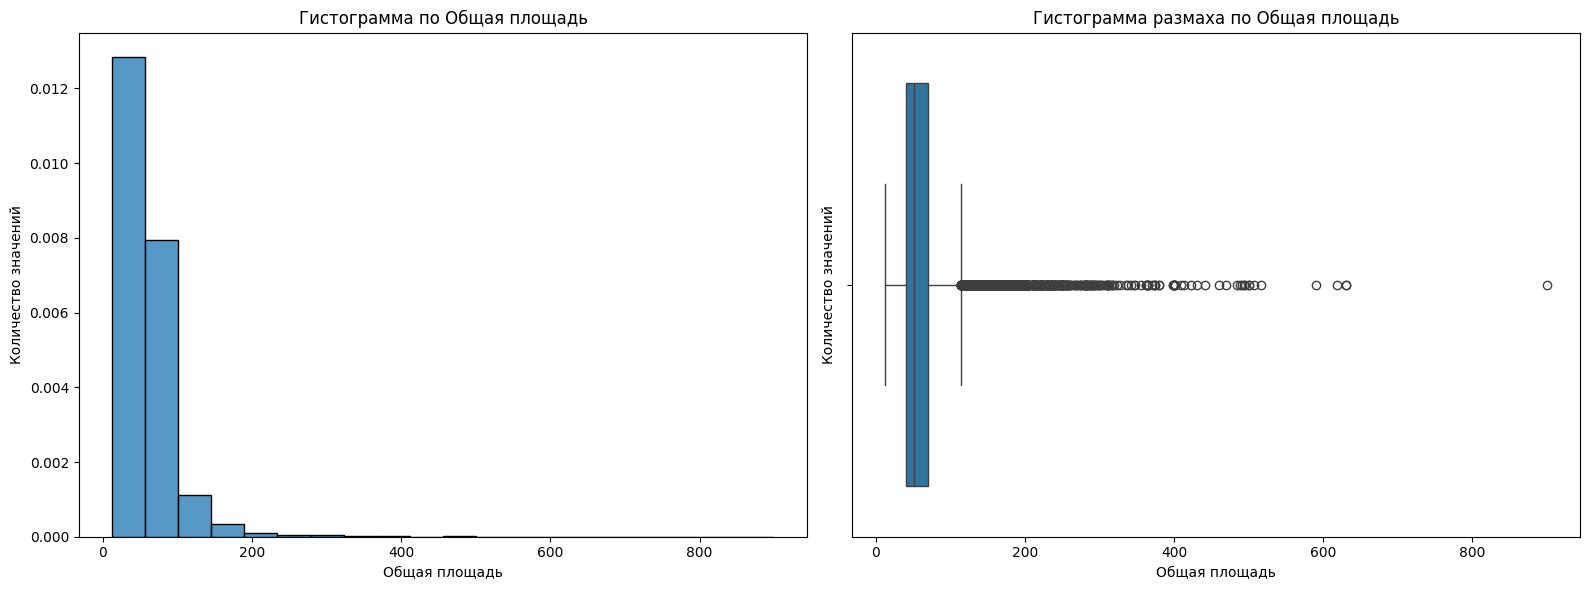

In [59]:
# Построим гистограмму общей площади

num_diag(data, data['total_area'], 'Общая площадь', 'Количество значений')

In [60]:
data['total_area'].describe()

count    23699.000000
mean        60.348651
std         35.654083
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900000
max        900.000000
Name: total_area, dtype: float64

Можно сделать выводы, что в выборке по площади квартир мы имеем выборосы - это квартиры больше примерно 100 кв м, вполне возможно, что квартиры большого метража существуют и это не ошибка. Оставим побольше данных, удалим только самые явные выбросы - квартиры больше 250 кв м.

In [61]:
# Избавимся из строк в датасете которые 

data = data[data['total_area'] < 250]

In [62]:
# Проверим, что строки удалены

data.describe()

total_images    last_price    total_area  \
count  23583.000000  2.358300e+04  23583.000000   
mean       9.845100  6.188881e+06     58.955657   
min        0.000000  1.219000e+04     12.000000   
25%        6.000000  3.400000e+06     40.000000   
50%        9.000000  4.600000e+06     52.000000   
75%       14.000000  6.700000e+06     69.000000   
max       50.000000  3.300000e+08    249.900000   
std        5.674231  7.044289e+06     28.789785   

                first_day_exposition         rooms  ceiling_height  \
count                          23583  23583.000000    14428.000000   
mean   2017-11-09 09:13:27.378196224      2.050969        2.767996   
min              2014-11-27 00:00:00      0.000000        1.000000   
25%              2017-05-13 00:00:00      1.000000        2.510000   
50%              2017-12-12 00:00:00      2.000000        2.650000   
75%              2018-08-26 00:00:00      3.000000        2.800000   
max              2019-05-03 00:00:00     14.000000      100.000000   
std                              NaN      1.027580        1.262653   

       floors_total   living_area         floor  kitchen_area       balcony  \
count  23583.000000  23583.000000  23583.000000  21322.000000  23583.000000   
mean      10.694483     33.742407      5.894924     10.460369      0.592333   
min        1.000000      2.000000      1.000000      1.300000      0.000000   
25%        5.000000     18.400000      2.000000      7.000000      0.000000   
50%        9.000000     30.200000      4.000000      9.100000      0.000000   
75%       16.000000     42.400000      8.000000     12.000000      1.000000   
max       60.000000    220.000000     33.000000    107.000000      5.000000   
std        6.599331     18.775970      4.888467      5.550088      0.959724   

       airports_nearest  city_centers_nearest  parks_around3000  \
count      23583.000000          23583.000000      23583.000000   
mean       28315.004876          14003.833540          0.465590   
min            0.000000            181.000000          0.000000   
25%        21151.000000          10984.500000          0.000000   
50%        26726.000000          13095.000000          0.000000   
75%        34392.000000          15350.000000          1.000000   
max        84869.000000          65968.000000          3.000000   
std        11104.206657           7589.448722          0.744579   

       parks_nearest  ponds_around3000  ponds_nearest  days_exposition  \
count   23583.000000      23583.000000   23583.000000     23583.000000   
mean      166.935759          0.587457     198.713310       156.187126   
min         0.000000          0.000000       0.000000         0.000000   
25%         0.000000          0.000000       0.000000        22.000000   
50%         0.000000          0.000000       0.000000        73.000000   
75%       300.000000          1.000000     386.500000       198.000000   
max      3190.000000          3.000000    1344.000000      1580.000000   
std       306.739946          0.881287     305.281339       212.945137   

            price_m      week_day         month          year  \
count  2.358300e+04  23583.000000  23583.000000  23583.000000   
mean   9.882280e+04      2.568376      6.400628   2017.368401   
min    1.118300e+02      0.000000      1.000000   2014.000000   
25%    7.653061e+04      1.000000      3.000000   2017.000000   
50%    9.491525e+04      3.000000      6.000000   2017.000000   
75%    1.140351e+05      4.000000     10.000000   2018.000000   
max    1.736842e+06      6.000000     12.000000   2019.000000   
std    4.695713e+04      1.789341      3.491104      1.038838   

       city_centers_nearest_km  
count             23583.000000  
mean                 13.977908  
min                   0.000000  
25%                  11.000000  
50%                  13.000000  
75%                  15.000000  
max                  66.000000  
std                   7.598675

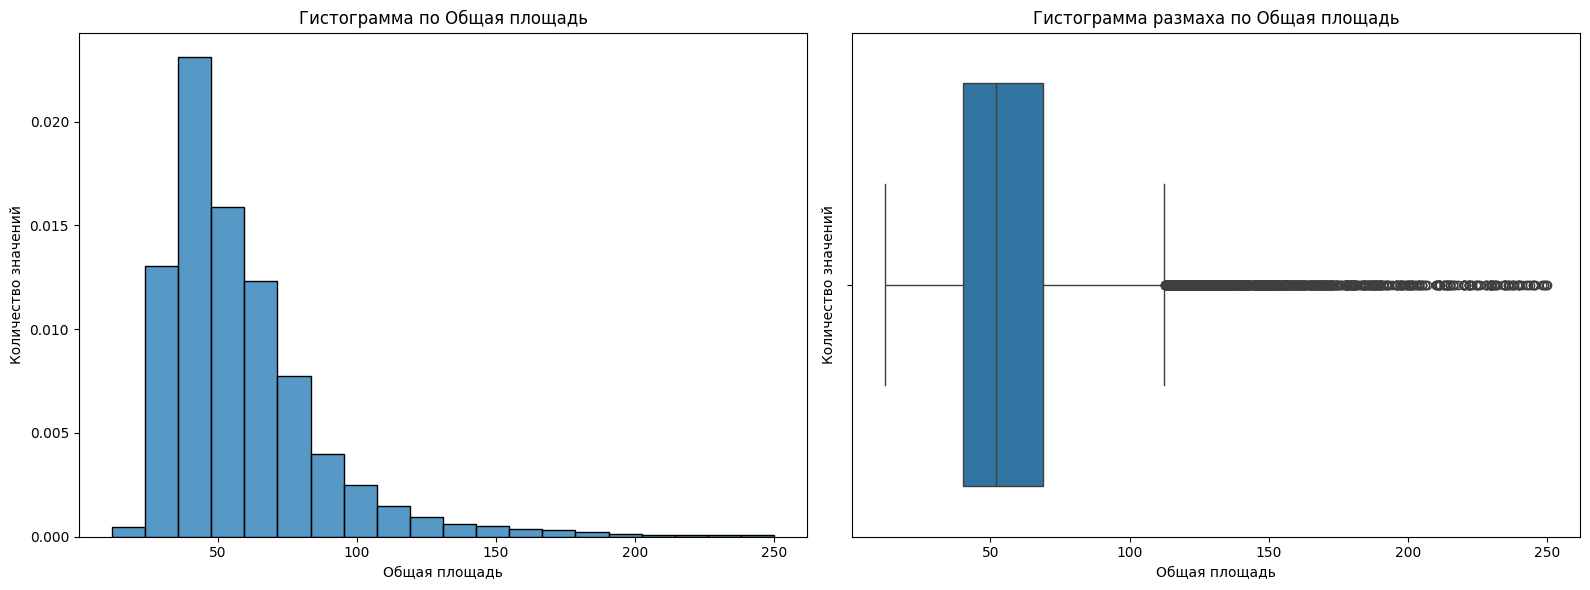

In [63]:
# Построим новую гистограмму total_area

num_diag(data, data['total_area'], 'Общая площадь', 'Количество значений')

После очистки получили диапазон площади квартир от 12 до 250 метров, что выглядит похожим на правду. Самые популярные квартиры примерно 43кв м - это однокомнатные квартиры, что ожидаемо.

In [64]:
data.shape

(23583, 28)

##### Исследование жилой площади living_area

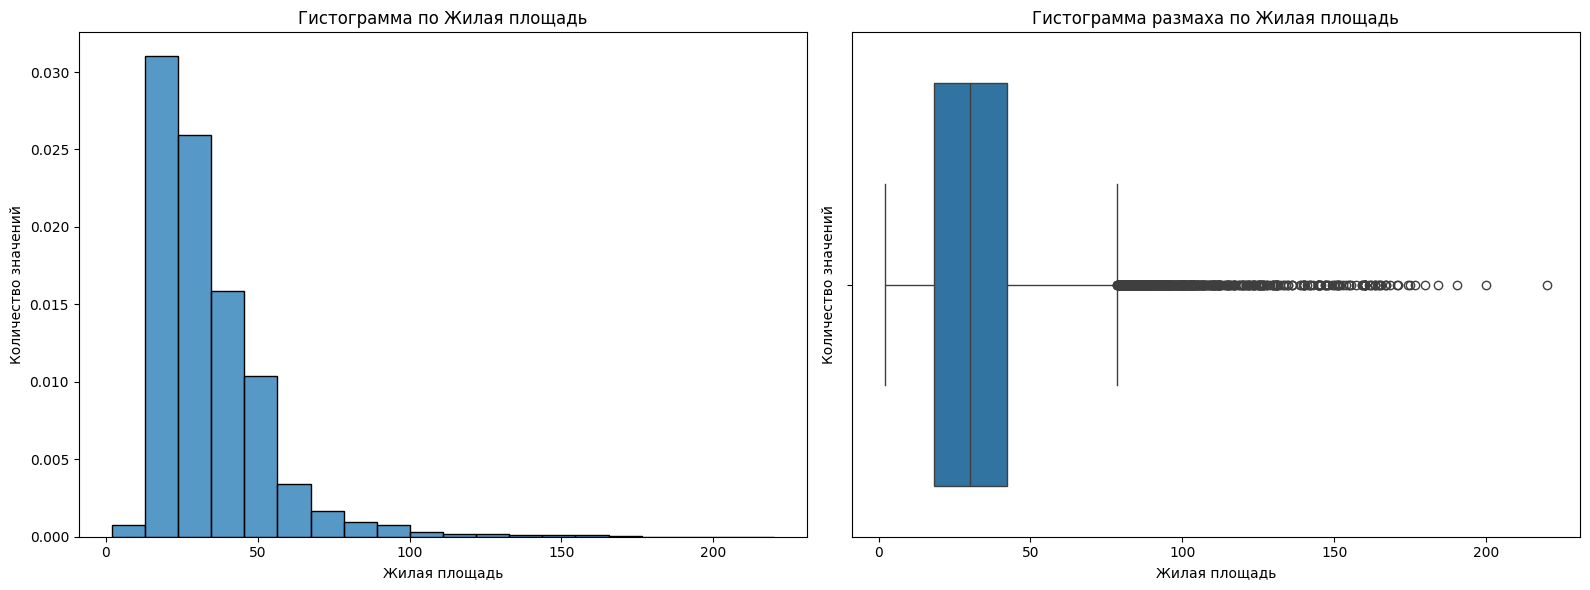

In [65]:
# Построим гистограмму жилой площади

num_diag(data, data['living_area'], 'Жилая площадь', 'Количество значений')

In [66]:
data['living_area'].describe()

count    23583.000000
mean        33.742407
std         18.775970
min          2.000000
25%         18.400000
50%         30.200000
75%         42.400000
max        220.000000
Name: living_area, dtype: float64

Можно сделать выводы, что в выборке по жилой площади квартир мы имеем выборосы - это квартиры с жилой площадью более примерно 75 кв м. Удалим самые явные выбросы - квартиры с жилой прощадью более 110м

In [67]:
# Избавимся от строк значения living_area которых больше 110м

data = data[data['living_area'] < 110]

In [68]:
# Проверим, что строки удалены

data.describe()

total_images    last_price    total_area  \
count  23392.000000  2.339200e+04  23392.000000   
mean       9.834131  5.987854e+06     57.841589   
min        0.000000  1.219000e+04     12.000000   
25%        6.000000  3.400000e+06     40.000000   
50%        9.000000  4.600000e+06     51.600000   
75%       14.000000  6.650000e+06     68.400000   
max       50.000000  3.300000e+08    249.700000   
std        5.664688  6.235775e+06     25.981892   

                first_day_exposition         rooms  ceiling_height  \
count                          23392  23392.000000    14290.000000   
mean   2017-11-10 10:20:23.803009536      2.022315        2.762178   
min              2014-11-27 00:00:00      0.000000        1.000000   
25%              2017-05-15 00:00:00      1.000000        2.500000   
50%              2017-12-13 00:00:00      2.000000        2.650000   
75%              2018-08-27 00:00:00      3.000000        2.800000   
max              2019-05-03 00:00:00      8.000000      100.000000   
std                              NaN      0.971888        1.266542   

       floors_total   living_area         floor  kitchen_area       balcony  \
count  23392.000000  23392.000000  23392.000000  21146.000000  23392.000000   
mean      10.730934     32.909152      5.908302     10.374264      0.593878   
min        1.000000      2.000000      1.000000      1.300000      0.000000   
25%        5.000000     18.300000      2.000000      7.000000      0.000000   
50%        9.000000     30.000000      4.000000      9.000000      0.000000   
75%       16.000000     42.000000      8.000000     11.900000      1.000000   
max       60.000000    109.510000     33.000000    107.000000      5.000000   
std        6.607977     16.317440      4.899496      5.433980      0.960149   

       airports_nearest  city_centers_nearest  parks_around3000  \
count       23392.00000          23392.000000      23392.000000   
mean        28341.64894          14071.769284          0.459345   
min             0.00000            181.000000          0.000000   
25%         21087.50000          11082.000000          0.000000   
50%         26726.00000          13095.000000          0.000000   
75%         34491.25000          15372.000000          1.000000   
max         84869.00000          65968.000000          3.000000   
std         11130.55235           7567.396456          0.737872   

       parks_nearest  ponds_around3000  ponds_nearest  days_exposition  \
count   23392.000000      23392.000000   23392.000000     23392.000000   
mean      165.920528          0.581994     197.922110       155.600932   
min         0.000000          0.000000       0.000000         0.000000   
25%         0.000000          0.000000       0.000000        23.000000   
50%         0.000000          0.000000       0.000000        73.000000   
75%       293.000000          1.000000     383.000000       197.000000   
max      3190.000000          3.000000    1344.000000      1580.000000   
std       306.920038          0.877147     305.188997       212.106302   

            price_m      week_day         month          year  \
count  2.339200e+04  23392.000000  23392.000000  23392.000000   
mean   9.838627e+04      2.568912      6.402958   2017.371067   
min    1.118300e+02      0.000000      1.000000   2014.000000   
25%    7.639089e+04      1.000000      3.000000   2017.000000   
50%    9.482759e+04      3.000000      6.000000   2017.000000   
75%    1.138612e+05      4.000000     10.000000   2018.000000   
max    1.736842e+06      6.000000     12.000000   2019.000000   
std    4.566856e+04      1.789711      3.492027      1.037519   

       city_centers_nearest_km  
count             23392.000000  
mean                 14.045357  
min                   0.000000  
25%                  11.000000  
50%                  13.000000  
75%                  15.000000  
max                  66.000000  
std                   7.577000

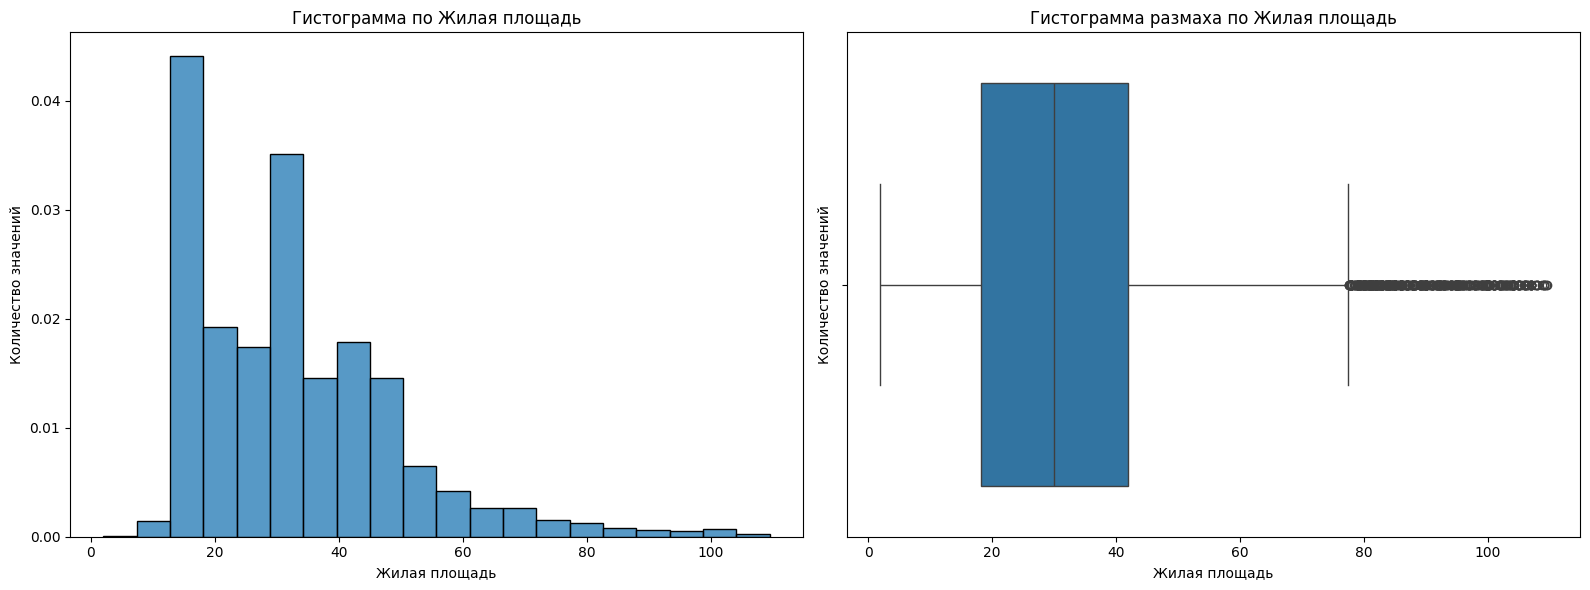

In [69]:
# Построим гистограмму жилой площади

num_diag(data, data['living_area'], 'Жилая площадь', 'Количество значений')

После очистки получили распределение c двумя пиками в примерно 18м и 30м, что соответствует 1 и 2х комнатным квартирам.

In [70]:
data.shape

(23392, 28)

##### Исследование площади кухни kitchen_area

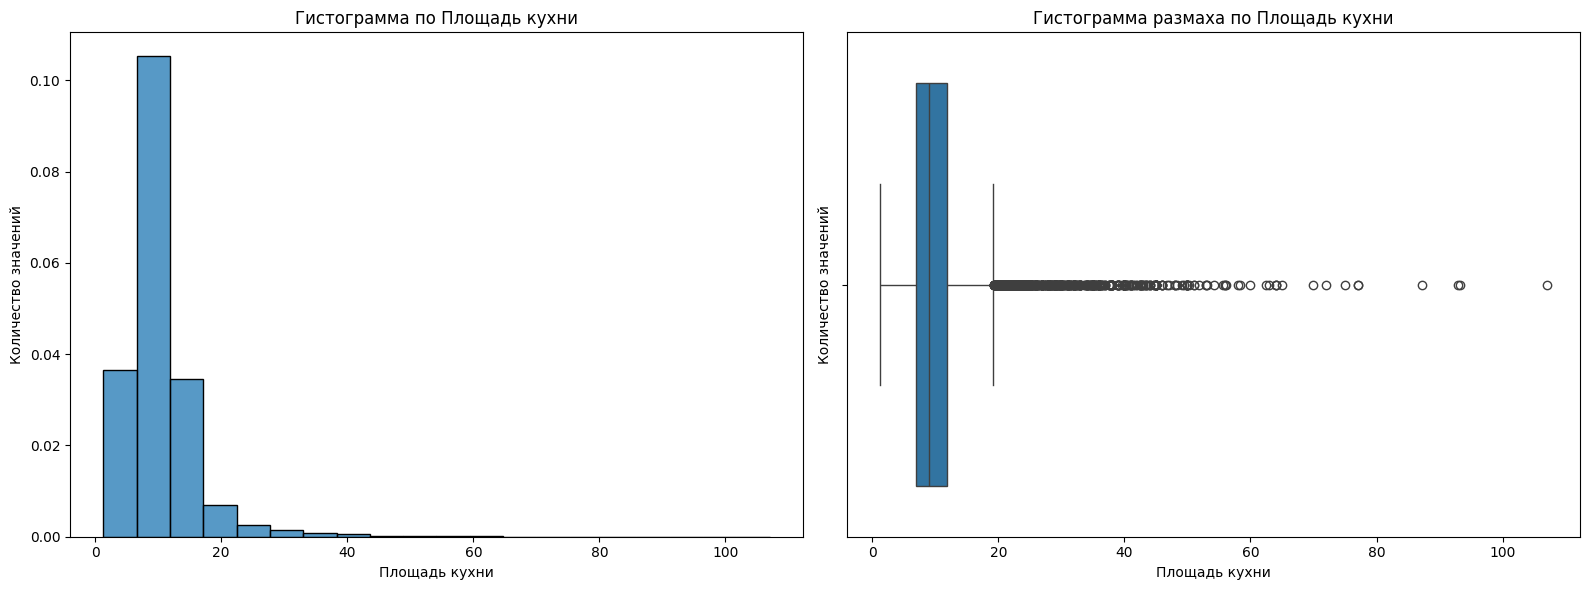

In [71]:
# Построим гистограмму площади кухни

num_diag(data, data['kitchen_area'], 'Площадь кухни', 'Количество значений')

In [72]:
data['kitchen_area'].describe()

count    21146.000000
mean        10.374264
std          5.433980
min          1.300000
25%          7.000000
50%          9.000000
75%         11.900000
max        107.000000
Name: kitchen_area, dtype: float64

После построения гистограммы и диаграммы размаха, видим что есть выбросы в площади кухонь от примерно 18м до 58м, удалим кухни больше 40м

In [73]:
# Избавимся от строк значения kitchen_area больше 40м
# Воспользуемся написанной ранее функцией low_high_limit

data = data[(data['kitchen_area'] < 40) | (data['kitchen_area'] == 'NaN')]

In [74]:
# Заменяем данные в колонке kitchen_area на среднее значение

data['kitchen_area'] = data['kitchen_area'].fillna(value=data['kitchen_area'].mean())

In [75]:
# Проверим, что строки удалены

data.describe()

total_images    last_price    total_area  \
count  21031.000000  2.103100e+04  21031.000000   
mean      10.006799  5.901528e+06     57.908623   
min        0.000000  4.300000e+05     14.000000   
25%        6.000000  3.490000e+06     40.200000   
50%       10.000000  4.650000e+06     52.000000   
75%       14.000000  6.650000e+06     68.500000   
max       50.000000  2.892384e+08    240.000000   
std        5.641779  5.370663e+06     25.005585   

                first_day_exposition         rooms  ceiling_height  \
count                          21031  21031.000000    13289.000000   
mean   2017-11-08 14:08:04.427749632      2.043317        2.754280   
min              2014-11-27 00:00:00      1.000000        1.000000   
25%              2017-05-08 00:00:00      1.000000        2.500000   
50%              2017-12-06 00:00:00      2.000000        2.650000   
75%              2018-09-03 00:00:00      3.000000        2.800000   
max              2019-05-03 00:00:00      8.000000      100.000000   
std                              NaN      0.953397        1.244396   

       floors_total   living_area         floor  kitchen_area      balcony  \
count  21031.000000  21031.000000  21031.000000  21031.000000  21031.00000   
mean      10.652085     32.997519      5.874091     10.162554      0.62755   
min        1.000000      2.000000      1.000000      1.300000      0.00000   
25%        5.000000     18.600000      2.000000      7.000000      0.00000   
50%        9.000000     30.000000      4.000000      9.000000      0.00000   
75%       16.000000     42.000000      8.000000     11.780000      1.00000   
max       60.000000    109.510000     33.000000     39.900000      5.00000   
std        6.550122     16.214001      4.849610      4.541497      0.97758   

       airports_nearest  city_centers_nearest  parks_around3000  \
count      21031.000000          21031.000000      21031.000000   
mean       28359.314155          14121.057988          0.462222   
min            0.000000            181.000000          0.000000   
25%        20895.000000          11087.000000          0.000000   
50%        26726.000000          13095.000000          0.000000   
75%        34625.500000          15418.500000          1.000000   
max        84869.000000          65968.000000          3.000000   
std        11199.691125           7637.532540          0.737480   

       parks_nearest  ponds_around3000  ponds_nearest  days_exposition  \
count   21031.000000      21031.000000   21031.000000     21031.000000   
mean      166.687889          0.584043     198.833959       158.716942   
min         0.000000          0.000000       0.000000         0.000000   
25%         0.000000          0.000000       0.000000        21.000000   
50%         0.000000          0.000000       0.000000        77.000000   
75%       301.000000          1.000000     389.000000       203.000000   
max      3190.000000          3.000000    1344.000000      1580.000000   
std       305.182163          0.878853     305.702078       214.495936   

            price_m      week_day         month          year  \
count  2.103100e+04  21031.000000  21031.000000  21031.000000   
mean   9.772101e+04      2.550663      6.423660   2017.364129   
min    9.615380e+03      0.000000      1.000000   2014.000000   
25%    7.650000e+04      1.000000      3.000000   2017.000000   
50%    9.466747e+04      2.000000      6.000000   2017.000000   
75%    1.133333e+05      4.000000     10.000000   2018.000000   
max    1.542605e+06      6.000000     12.000000   2019.000000   
std    4.198500e+04      1.784487      3.466758      1.043776   

       city_centers_nearest_km  
count             21031.000000  
mean                 14.095668  
min                   0.000000  
25%                  11.000000  
50%                  13.000000  
75%                  15.000000  
max                  66.000000  
std                   7.646019

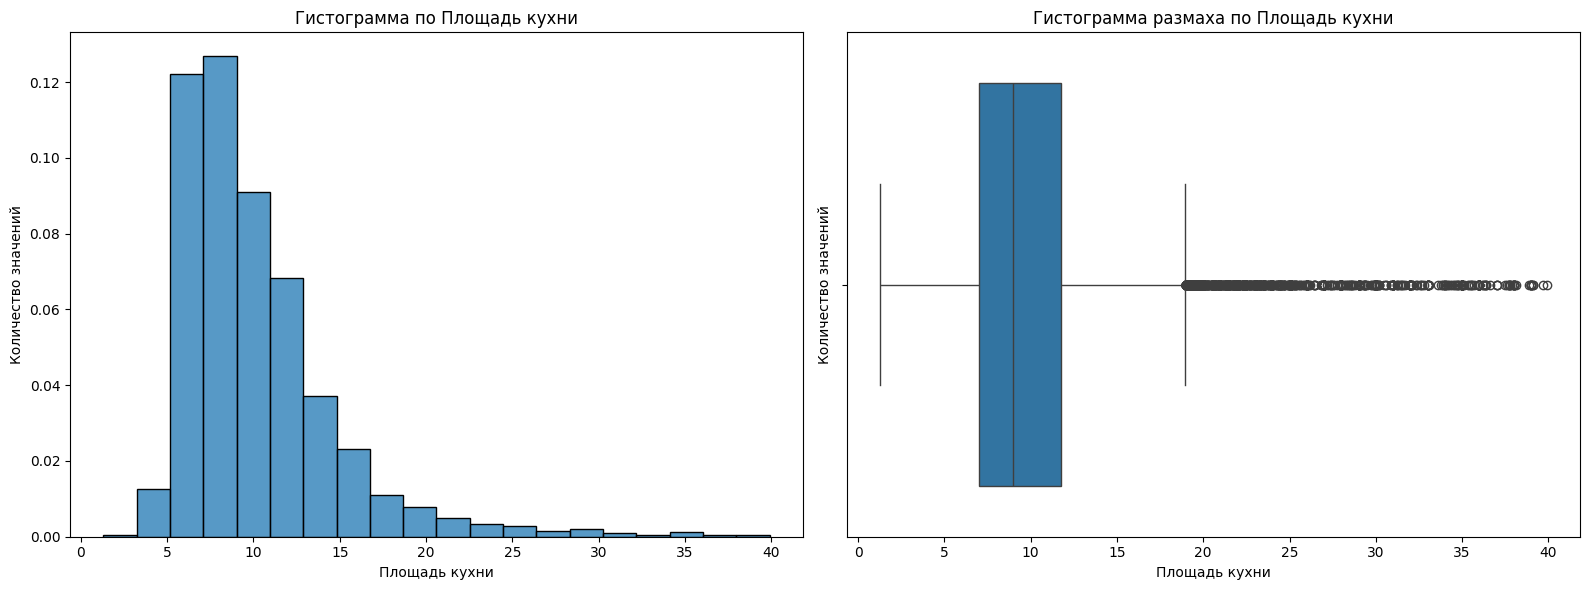

In [76]:
# Построим новую гистограмму площади кухни

num_diag(data, data['kitchen_area'], 'Площадь кухни', 'Количество значений')

После очистки данных по площади кухни от аномалий получили распредение с пиком на примерно 11 кв. м. думаю это соответствует реальности.

In [77]:
data.shape

(21031, 28)

##### Исследование цены объекта last_price

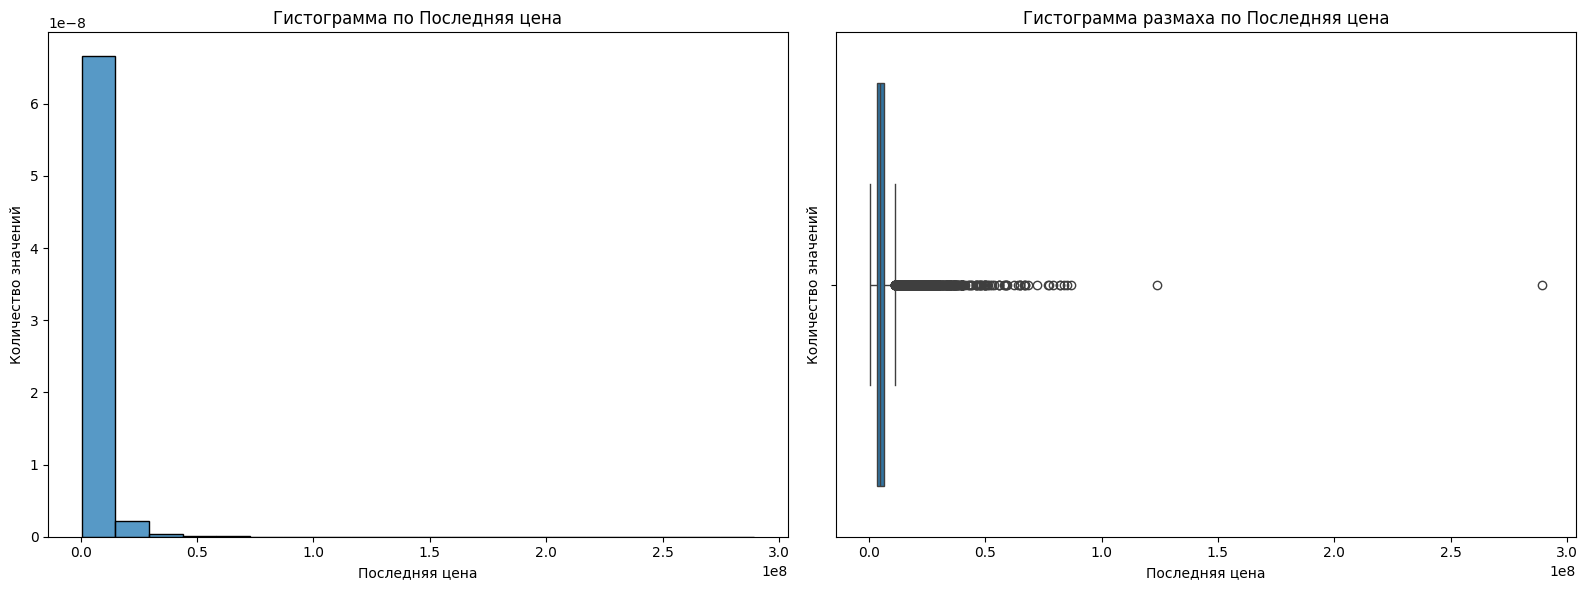

In [78]:
# Построим гистограмму последней цены

num_diag(data, data['last_price'], 'Последняя цена', 'Количество значений')

In [79]:
data['last_price'].describe()

count    2.103100e+04
mean     5.901528e+06
std      5.370663e+06
min      4.300000e+05
25%      3.490000e+06
50%      4.650000e+06
75%      6.650000e+06
max      2.892384e+08
Name: last_price, dtype: float64

После построения гистограммы и диаграммы размаха, видим что есть выбросы в цене квартир. Это квартиры дороже примерно 10 млн. Чтобы не терять данные удалим только сильно выбивающиеся значения - квартиры дороже 25 млн


In [81]:
# Избавимся от строк значения last_price больше 25 млн 
# Воспользуемся написанной ранее функцией low_high_limit

data = data[data['last_price'] < 25000000]

In [82]:
# Проверим, что строки удалены

data.describe()

total_images    last_price    total_area  \
count  20790.000000  2.079000e+04  20790.000000   
mean       9.977682  5.527597e+06     56.984831   
min        0.000000  4.300000e+05     14.000000   
25%        6.000000  3.450000e+06     40.000000   
50%       10.000000  4.600000e+06     51.500000   
75%       14.000000  6.500000e+06     67.800000   
max       50.000000  2.490000e+07    240.000000   
std        5.618971  3.391203e+06     23.360306   

                first_day_exposition         rooms  ceiling_height  \
count                          20790  20790.000000    13122.000000   
mean   2017-11-10 02:00:06.233766400      2.027561        2.749893   
min              2014-11-27 00:00:00      1.000000        1.000000   
25%              2017-05-10 00:00:00      1.000000        2.500000   
50%              2017-12-06 12:00:00      2.000000        2.650000   
75%              2018-09-04 00:00:00      3.000000        2.800000   
max              2019-05-03 00:00:00      8.000000      100.000000   
std                              NaN      0.941893        1.251173   

       floors_total   living_area         floor  kitchen_area       balcony  \
count  20790.000000  20790.000000  20790.000000  20790.000000  20790.000000   
mean      10.666426     32.517412      5.869745     10.049022      0.626118   
min        1.000000      2.000000      1.000000      1.300000      0.000000   
25%        5.000000     18.500000      2.000000      7.000000      0.000000   
50%        9.000000     30.000000      4.000000      9.000000      0.000000   
75%       16.000000     41.900000      8.000000     11.500000      1.000000   
max       60.000000    109.000000     33.000000     39.900000      5.000000   
std        6.567234     15.518838      4.854412      4.371050      0.974168   

       airports_nearest  city_centers_nearest  parks_around3000  \
count      20790.000000          20790.000000      20790.000000   
mean       28368.518470          14214.684160          0.452333   
min            0.000000            208.000000          0.000000   
25%        20822.250000          11220.000000          0.000000   
50%        26726.000000          13095.000000          0.000000   
75%        34815.000000          15453.000000          1.000000   
max        84869.000000          65968.000000          3.000000   
std        11241.640287           7620.111672          0.727750   

       parks_nearest  ponds_around3000  ponds_nearest  days_exposition  \
count   20790.000000      20790.000000   20790.000000     20790.000000   
mean      164.983405          0.571958     197.490476       157.988215   
min         0.000000          0.000000       0.000000         0.000000   
25%         0.000000          0.000000       0.000000        21.250000   
50%         0.000000          0.000000       0.000000        77.000000   
75%       293.000000          1.000000     382.000000       202.000000   
max      3190.000000          3.000000    1344.000000      1580.000000   
std       304.353800          0.867804     305.871562       213.268617   

             price_m      week_day         month          year  \
count   20790.000000  20790.000000  20790.000000  20790.000000   
mean    95518.840421      2.551756      6.419913   2017.368543   
min      9615.380000      0.000000      1.000000   2014.000000   
25%     76160.975000      1.000000      3.000000   2017.000000   
50%     94282.895000      2.000000      6.000000   2017.000000   
75%    112439.172500      4.000000     10.000000   2018.000000   
max    640422.350000      6.000000     12.000000   2019.000000   
std     33506.150219      1.785099      3.465991      1.039927   

       city_centers_nearest_km  
count             20790.000000  
mean                 14.189418  
min                   0.000000  
25%                  11.000000  
50%                  13.000000  
75%                  15.000000  
max                  66.000000  
std                   7.628320

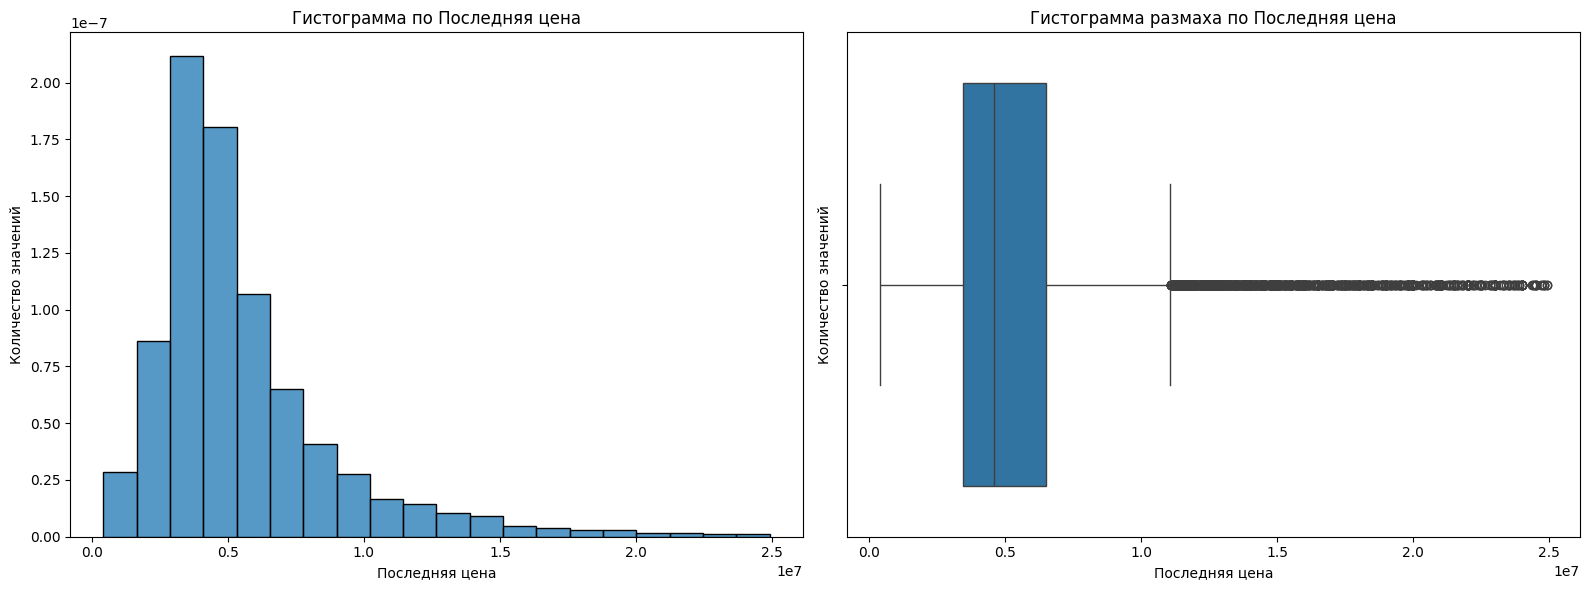

In [83]:
# Построим новую гистограмму площади кухни

num_diag(data, data['last_price'], 'Последняя цена', 'Количество значений')

После очистки данных по последней цене квартиры от аномалий получили похожее на нормальное распредение с пиком на примерно 4 млн. 

In [84]:
data.shape

(20790, 28)

##### Исследование количества комнат rooms

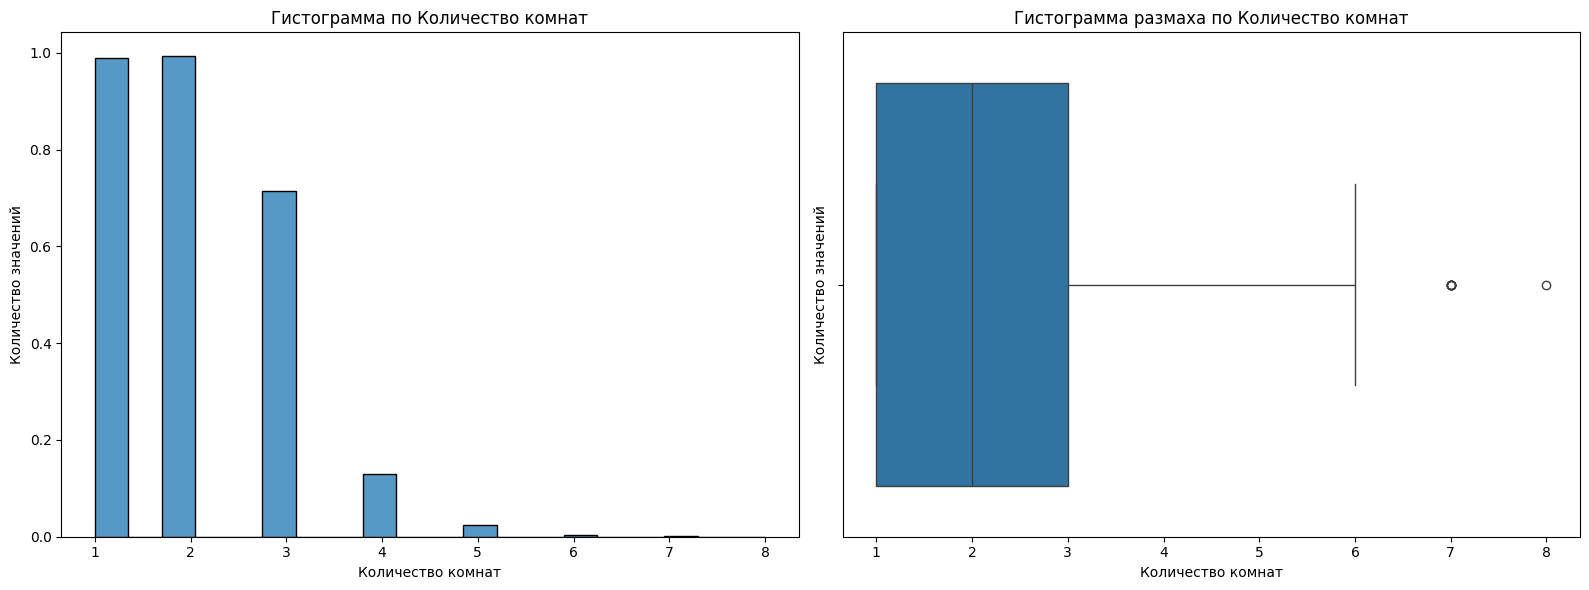

In [85]:
# Построим гистограмму количества комнат

num_diag(data, data['rooms'], 'Количество комнат', 'Количество значений')

In [86]:
# Квартир больше 6 комнат посчти нет, удалим эти выбросы

data = data[data['rooms'] <= 6]

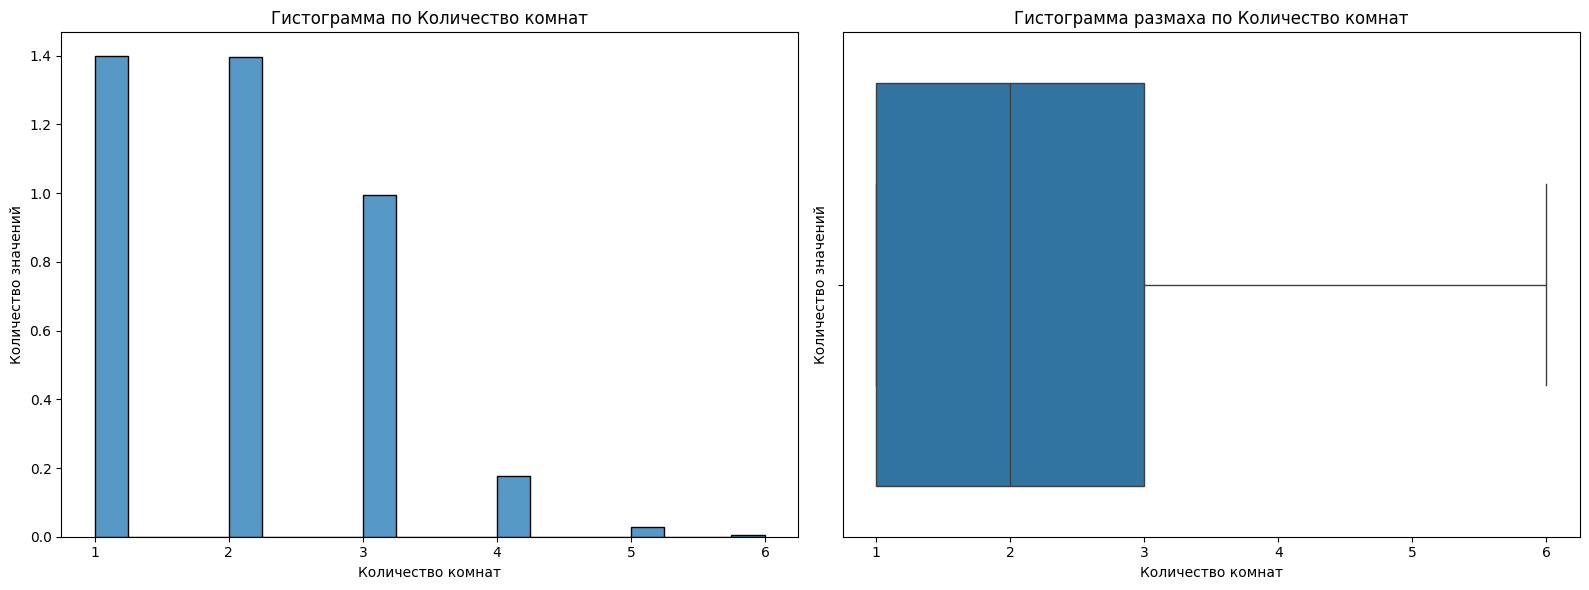

In [107]:
# Построим гистограмму количества комнат

num_diag(data, data['rooms'], 'Количество комнат', 'Количество значений')

Данные очищенны, выбросов больше нет. 

##### Исследование высоты потолков ceiling_height

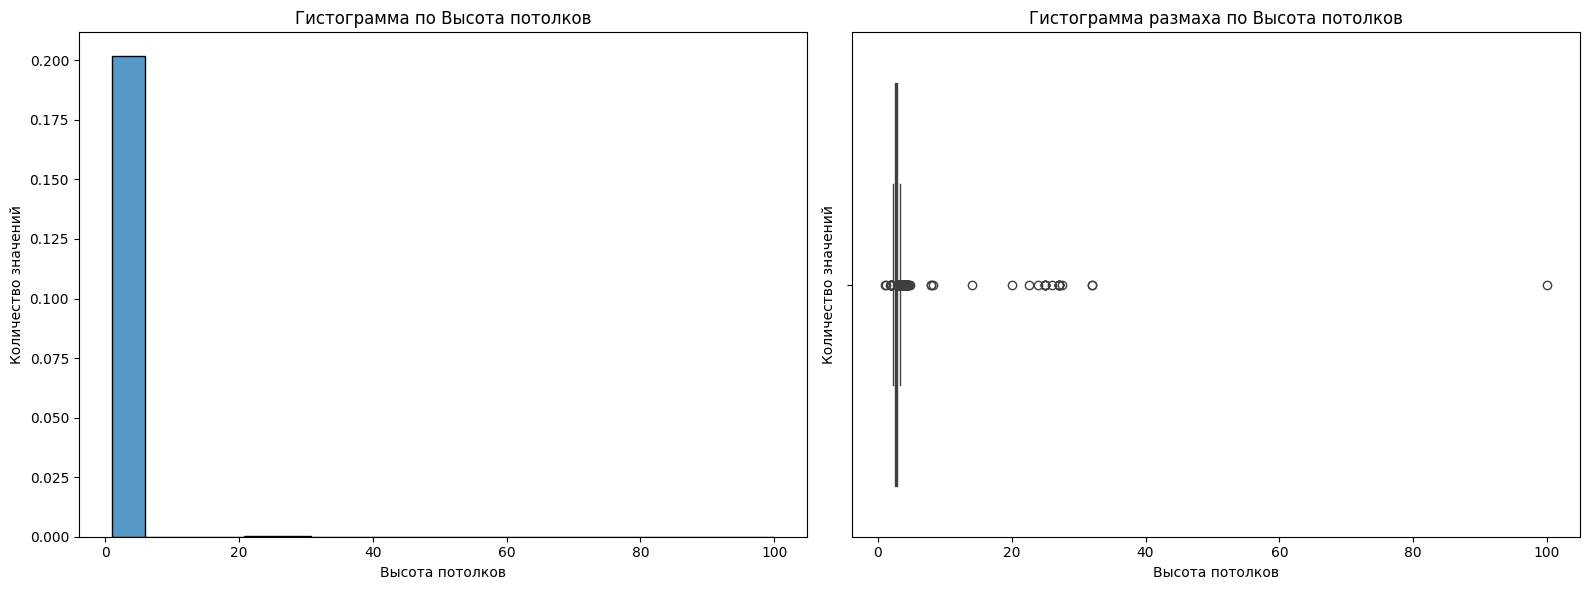

In [88]:
# Построим гистограмму высоты потолка

num_diag(data, data['ceiling_height'], 'Высота потолков', 'Количество значений')

In [90]:
data['ceiling_height'].describe()

count    13116.000000
mean         2.749751
std          1.251436
min          1.000000
25%          2.500000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

Как можно заметить по диаграмме размаха, разброс значений слишком велик и данные о потолках выше 8-10м выглядят не правдоподобно, скорее всего мы имеем ошибки в данных. Скорее всего в значениях 20-32м не поставили точку между цифрами. Попробуем это исправить

In [91]:
# Посмотрим данные с высотой потолков от 20м и выше

data[data['ceiling_height'] >= 20].head()

total_images  last_price  total_area first_day_exposition  rooms  \
3148            14   2900000.0        75.0           2018-11-12      3   
4643             0   4300000.0        45.0           2018-02-01      2   
5076             0   3850000.0        30.5           2018-10-03      1   
5246             0   2500000.0        54.0           2017-10-13      2   
5669             4   4400000.0        50.0           2017-08-08      2   

      ceiling_height  floors_total  living_area  floor  is_apartment  studio  \
3148            32.0             3         53.0      2          True   False   
4643            25.0             9         30.0      2          True   False   
5076            24.0             5         19.5      1          True   False   
5246            27.0             5         30.0      3          True   False   
5669            26.0             9         21.3      3          True   False   

      open_plan  kitchen_area  balcony    locality_name  airports_nearest  \
3148      False           8.0        0           Волхов           26726.0   
4643      False           7.0        1  Санкт-Петербург           12016.0   
5076      False           5.5        0  Санкт-Петербург           29686.0   
5246      False           9.0        2             Мины           26726.0   
5669      False           7.0        2  Санкт-Петербург           28981.0   

      city_centers_nearest  parks_around3000  parks_nearest  ponds_around3000  \
3148               13095.0                 0            0.0                 0   
4643               13256.0                 1          658.0                 1   
5076                8389.0                 3          397.0                 1   
5246               13095.0                 0            0.0                 0   
5669               10912.0                 1          305.0                 0   

      ponds_nearest  days_exposition    price_m  week_day  month  year  \
3148            0.0                0   38666.67         0     11  2018   
4643          331.0              181   95555.56         3      2  2018   
5076          578.0                7  126229.51         2     10  2018   
5246            0.0              540   46296.30         4     10  2017   
5669            0.0              267   88000.00         1      8  2017   

     floor_type  city_centers_nearest_km  
3148     другой                       13  
4643     другой                       13  
5076     первый                        8  
5246     другой                       13  
5669     другой                       11

Судя по данным это вполне обычные квартиры, расположенные в домах имеющих несколько этажей, что было бы не возможно с такой высотой потолков. Попробуем восстановить данные - исправим ошибочные значения.

In [92]:
# Применим лямбда функцию к колонке ceiling_height которая все значения больше 20 разделит на 10

data['ceiling_height'] = data['ceiling_height'].apply(lambda x: x/10 if x >= 20 else x)

In [93]:
# Проверим что все получилось

data[data['ceiling_height'] >= 20]

Empty DataFrame
Columns: [total_images, last_price, total_area, first_day_exposition, rooms, ceiling_height, floors_total, living_area, floor, is_apartment, studio, open_plan, kitchen_area, balcony, locality_name, airports_nearest, city_centers_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest, days_exposition, price_m, week_day, month, year, floor_type, city_centers_nearest_km]
Index: []

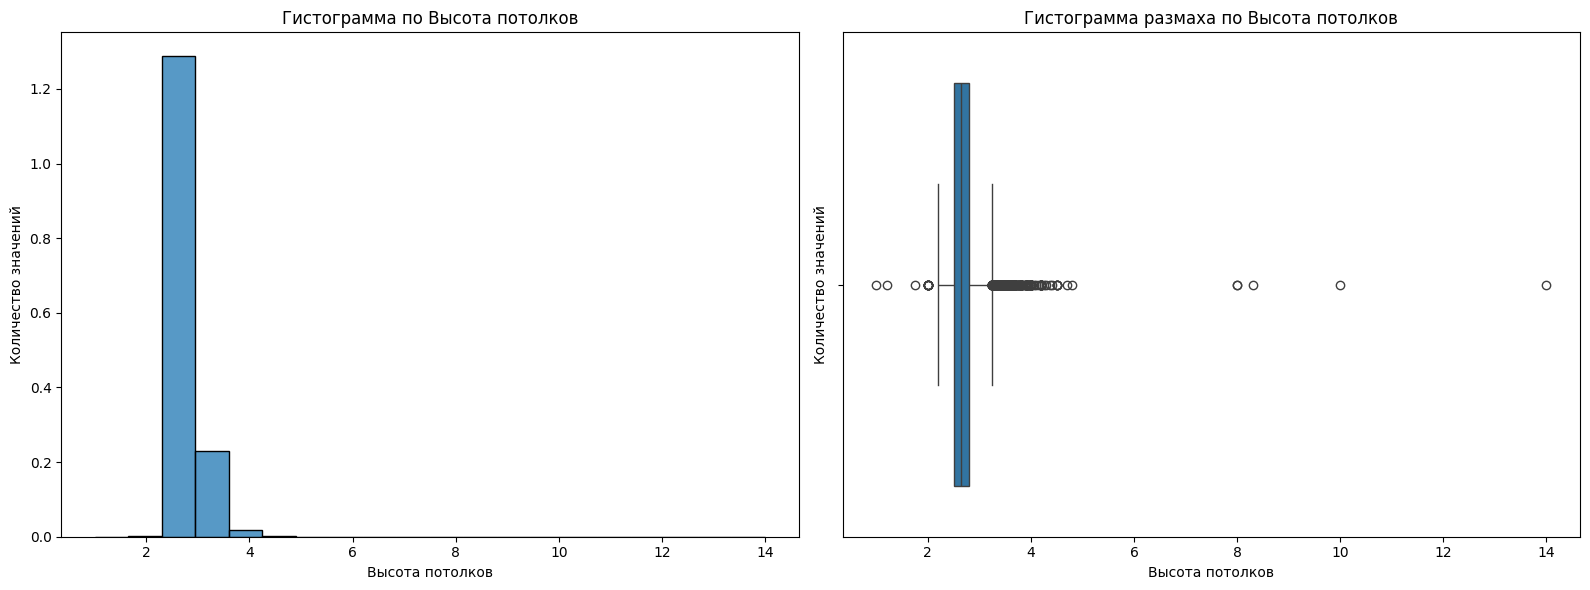

In [94]:
# Построим диаграмму размаха высоты потолка

num_diag(data, data['ceiling_height'], 'Высота потолков', 'Количество значений')

У нас все еще остались ошибочные значения и выбросы. Врядли существуют квартиры с высотой потолков меньше 2м и квартир с высотой потолков больше 3.5 м также не много, это ошибки или выбросы в данных. Удалим их.

In [95]:
# Заменим пропуски в колонке ceiling_height на среднее значение

data['ceiling_height'] = data['ceiling_height'].fillna(value=data['ceiling_height'].median())

In [96]:
# Избавимся от строк значения ceiling_height которых не входят в интервал от 2х до 3.5 м

data = data[(data['ceiling_height'] > 2) & 
            (data['ceiling_height'] < 3.5)]

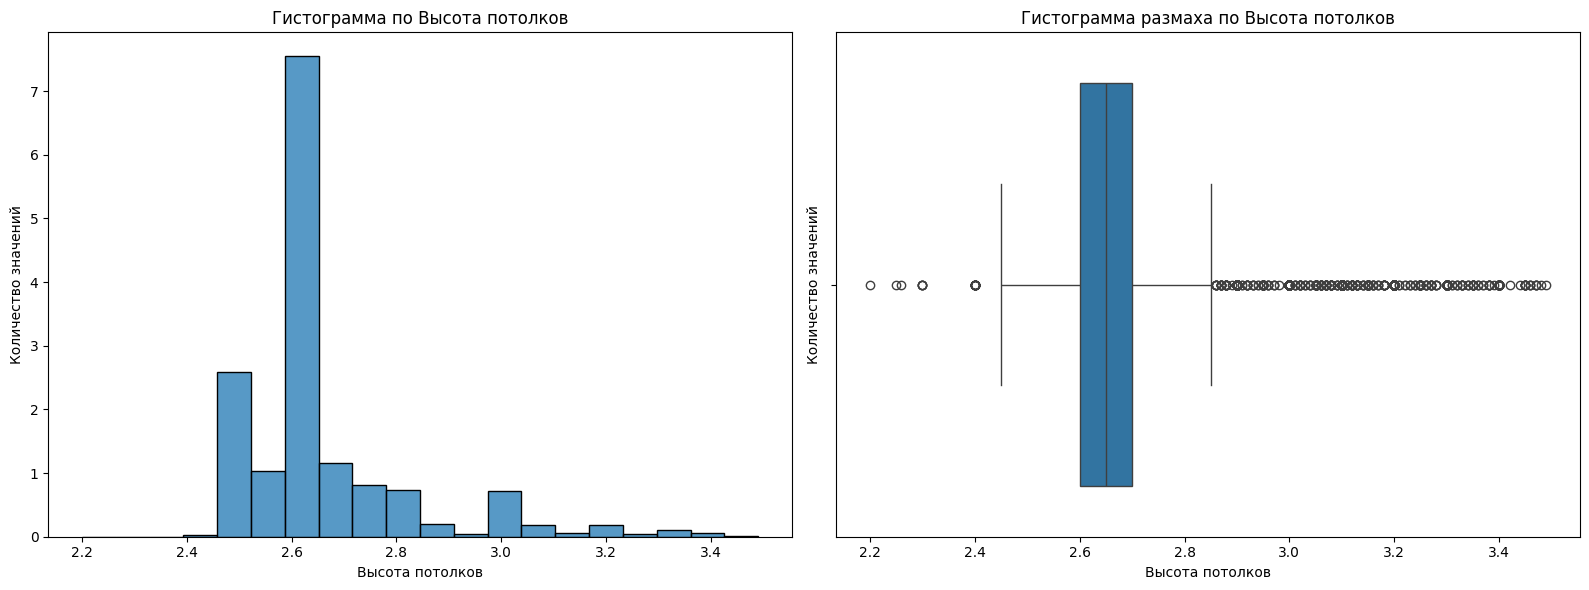

In [97]:
# Построим гистограмму высоты потолка снова

num_diag(data, data['ceiling_height'], 'Высота потолков', 'Количество значений')

У нас остались квартиры с высотой потолков от 2,4 м до 3,5 м, думаю это нормально.

In [98]:
data.shape

(20489, 28)

##### Исследование типа этажа квартиры floor_type

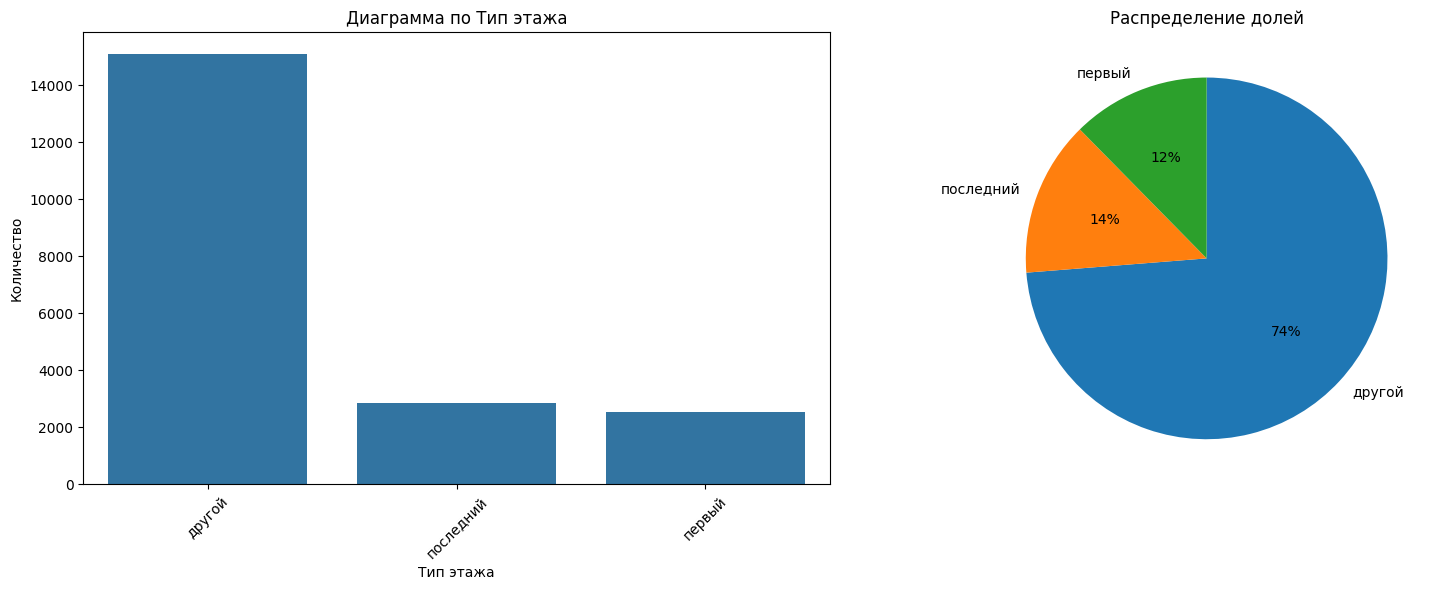

In [105]:
# Построим гистограмму типа этажа квартиры

cat_diag(data, 'floor_type', 'Тип этажа')

Очевидно, что квартир на первом или последнем этаже квартир меньше чем на других этажах вместе взятых. Думаю тут нет проблем с данными, оставим их как есть. 

In [108]:
data.shape

(20489, 28)

##### Исследование общего количества этажей в доме floors_total

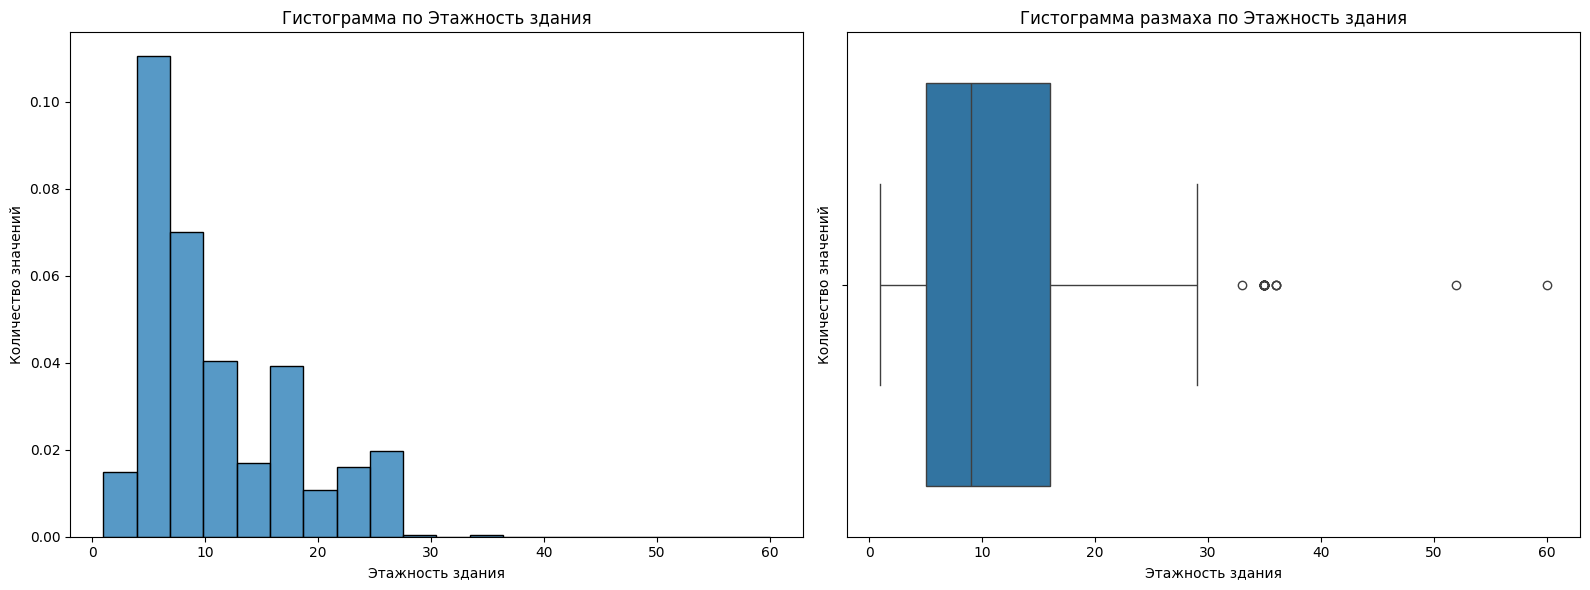

In [109]:
# Построим гистограмму количества этажей в доме

num_diag(data, data['floors_total'], 'Этажность здания', 'Количество значений')

In [110]:
data['floors_total'].describe()

count    20489.000000
mean        10.742057
std          6.572337
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

По диаграмме размаха и гистограмме мы видим, что несколько квартир выбивается - это квартиры в домах имеющих больше 30 этажей. Удалим эти выбросы.

In [111]:
# Избавимся от строк значения ceiling_height которые больше 30
# Воспользуемся написанной ранее функцией low_high_limit

data = data[data['floors_total'] < 30]

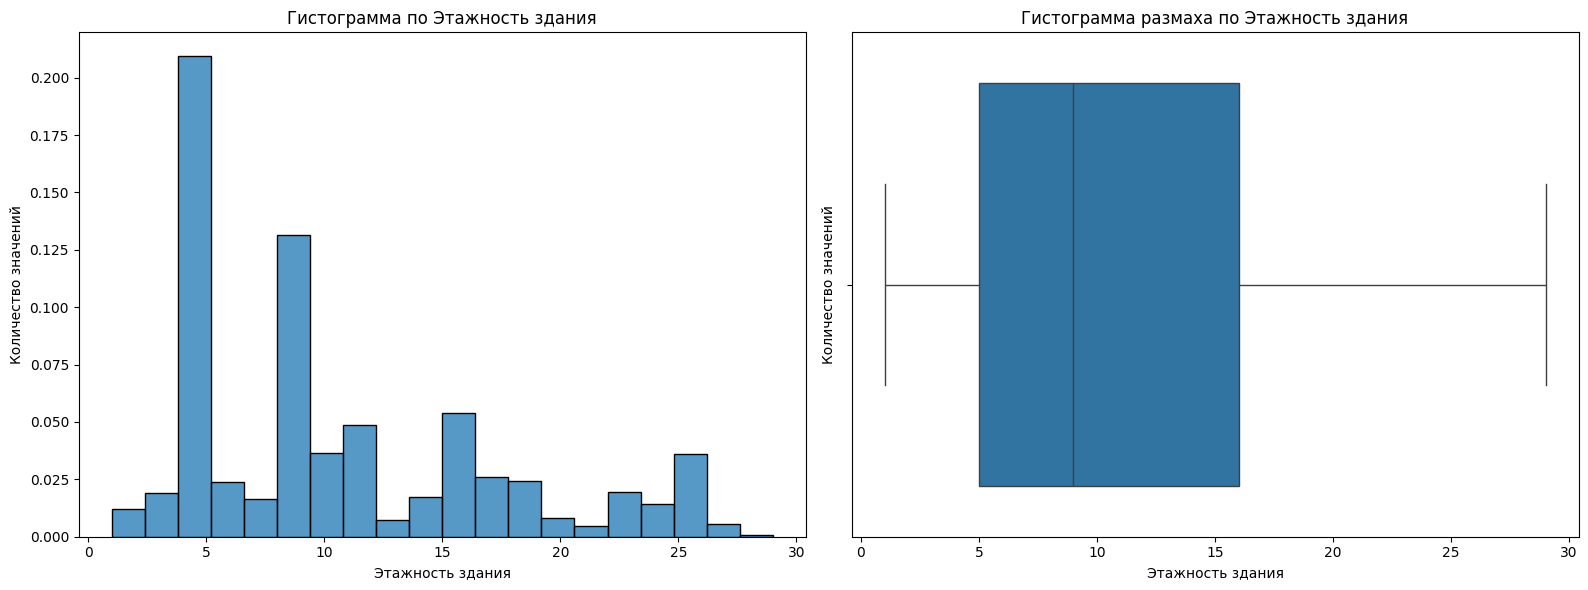

In [113]:
# Построим гистограмму этажности еще раз

num_diag(data, data['floors_total'], 'Этажность здания', 'Количество значений')

Самые популярые это 5ти и 9ти этажки, выглядит вполне реалистично.

In [114]:
data.shape

(20461, 28)

##### Исследование расстояний до центра города city_centers_nearest

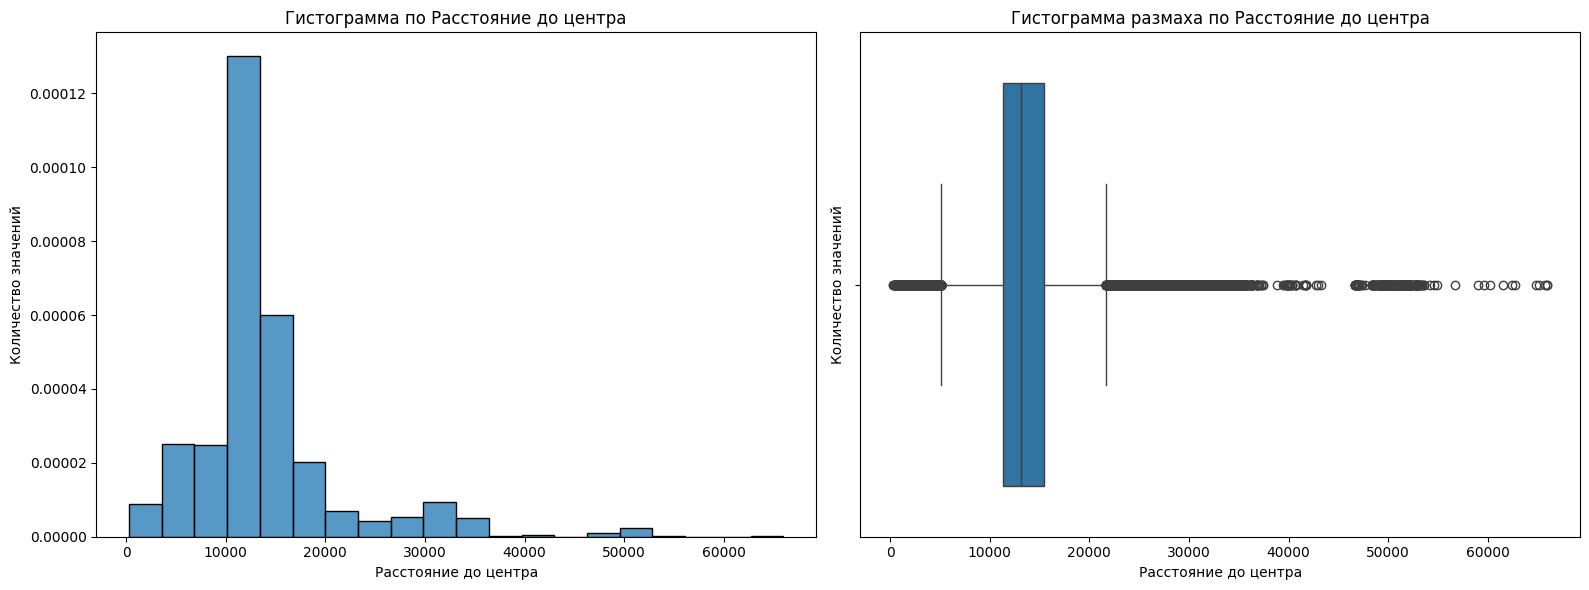

In [115]:
# Построим гистограмму расстояния до центра

num_diag(data, data['city_centers_nearest'], 'Расстояние до центра', 'Количество значений')

In [116]:
data['city_centers_nearest'].describe()

count    20461.000000
mean     14310.349967
std       7553.722262
min        287.000000
25%      11348.000000
50%      13095.000000
75%      15480.000000
max      65968.000000
Name: city_centers_nearest, dtype: float64

Судя по диаграме размаха и гистограмме в данных много выбросов, однако данные с расстояниями до центра нам понадобятся дальше, поэтому удалим только самые явные выбросы - это квартиры с расстоянием более 60 тыс м от центра.

In [117]:
# Удалим значения city_centers_nearest более 60 км

data = data[data['city_centers_nearest'] < 60000]

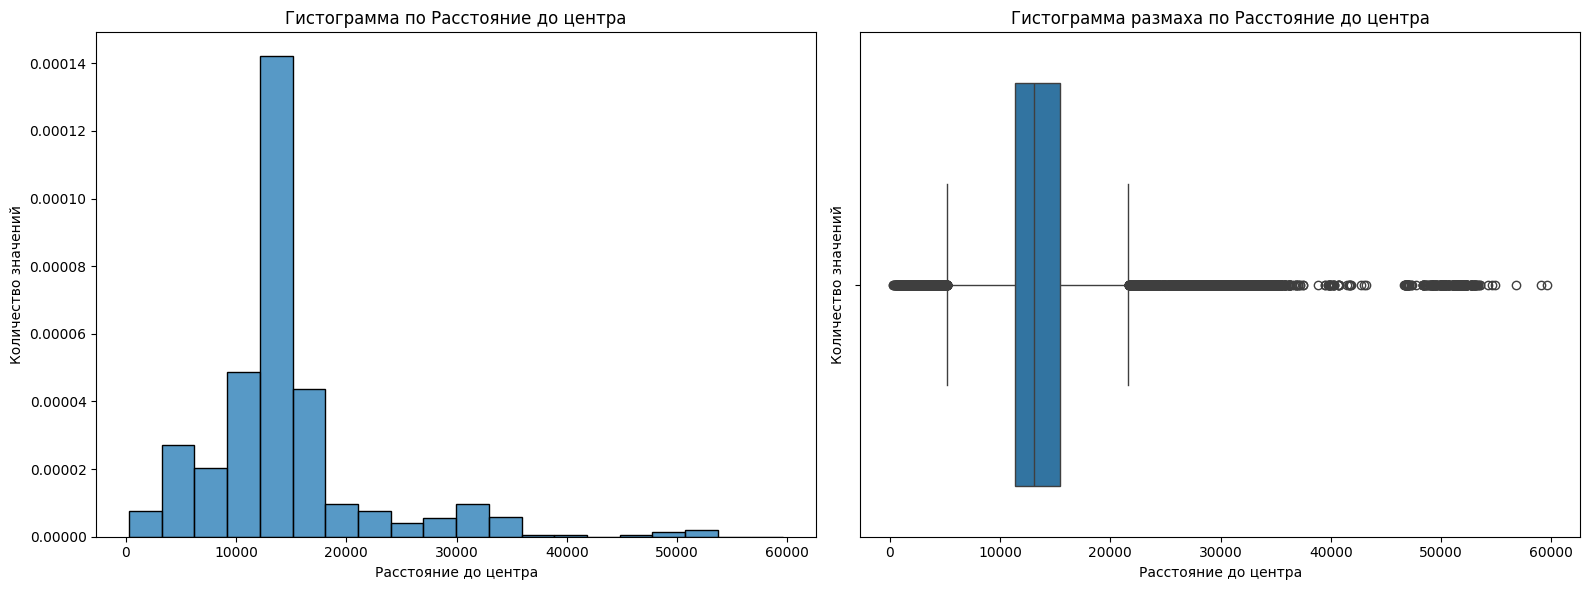

In [ ]:
# Построим гистограмму расстояния до центра

num_diag(data, data['city_centers_nearest'], 'Расстояние до центра', 'Количество значений')

Большинство квартир находятся на расстоянии 10-17 км от центра, видимо это золотая середина между стоимостью и транспортной доступностью.

In [119]:
data.shape

(20452, 28)

##### Исследование расстояний до ближайшего парка parks_nearest

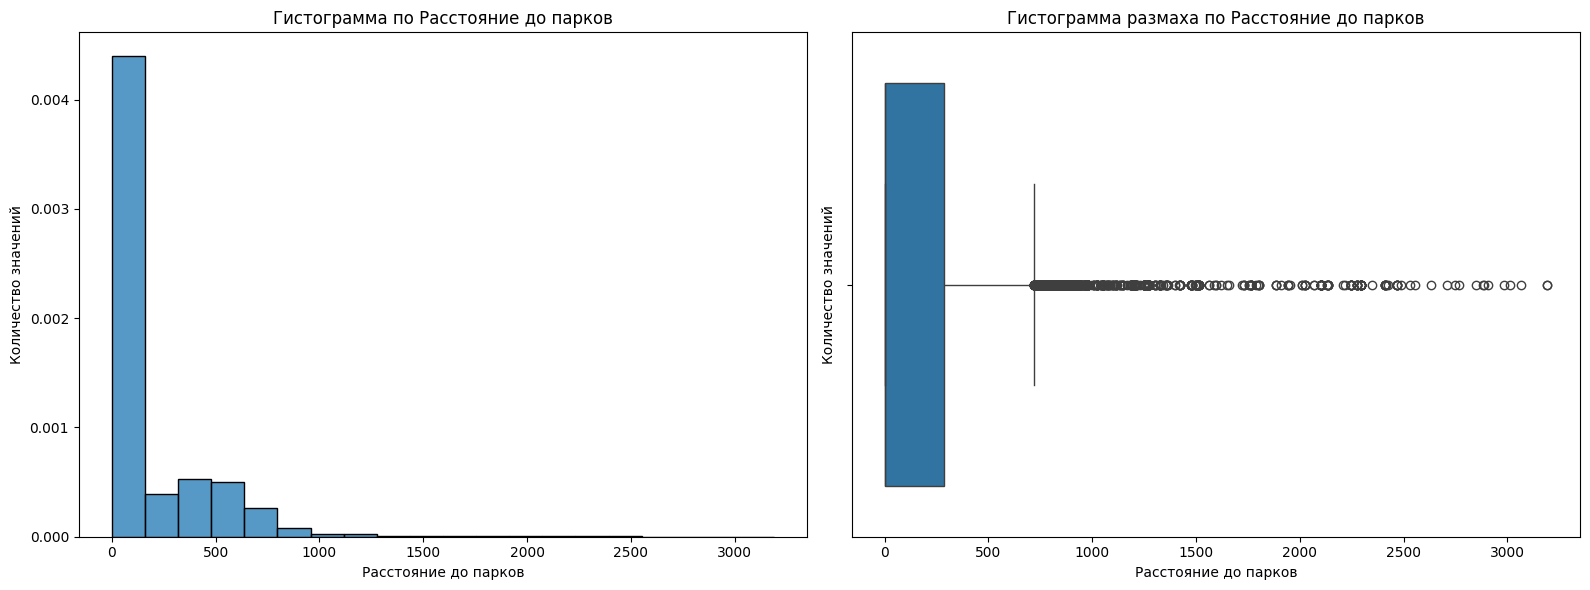

In [120]:
# Построим гистограмму расстояния до центра

num_diag(data, data['parks_nearest'], 'Расстояние до парков', 'Количество значений')

Из-за того что ранее мы заполнили пропущенные значения расстояний до парков нулями, получилось что на диаграмме размаха и гистограме нормальные значения попали в выбросы. Думаю выбросы это квартиры с растоянием до парков более 2500м. Удалим эти выбросы.

In [ ]:
# Удалим квартиры с расстоянем ло парков более 2500м

data = data[data['parks_nearest'] <= 2500]

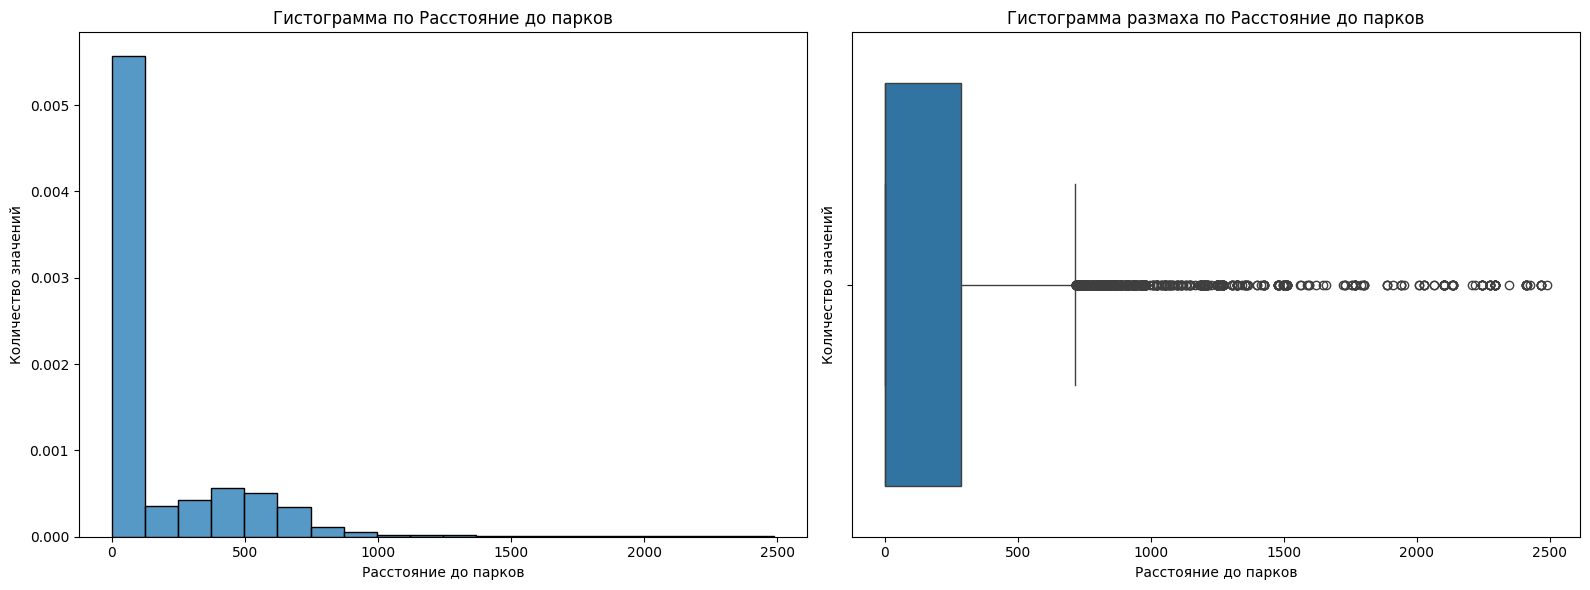

In [122]:
# Построим гистограмму расстояния до центра

num_diag(data, data['parks_nearest'], 'Расстояние до парков', 'Количество значений')

Если не считать нулевых значений, распределение похоже на нормальное. Больше всего квартир находятся на расстоянии 250-650м от парков.

In [123]:
data.shape

(20437, 28)

#### Изучение времени продажи квартир (days_exposition)

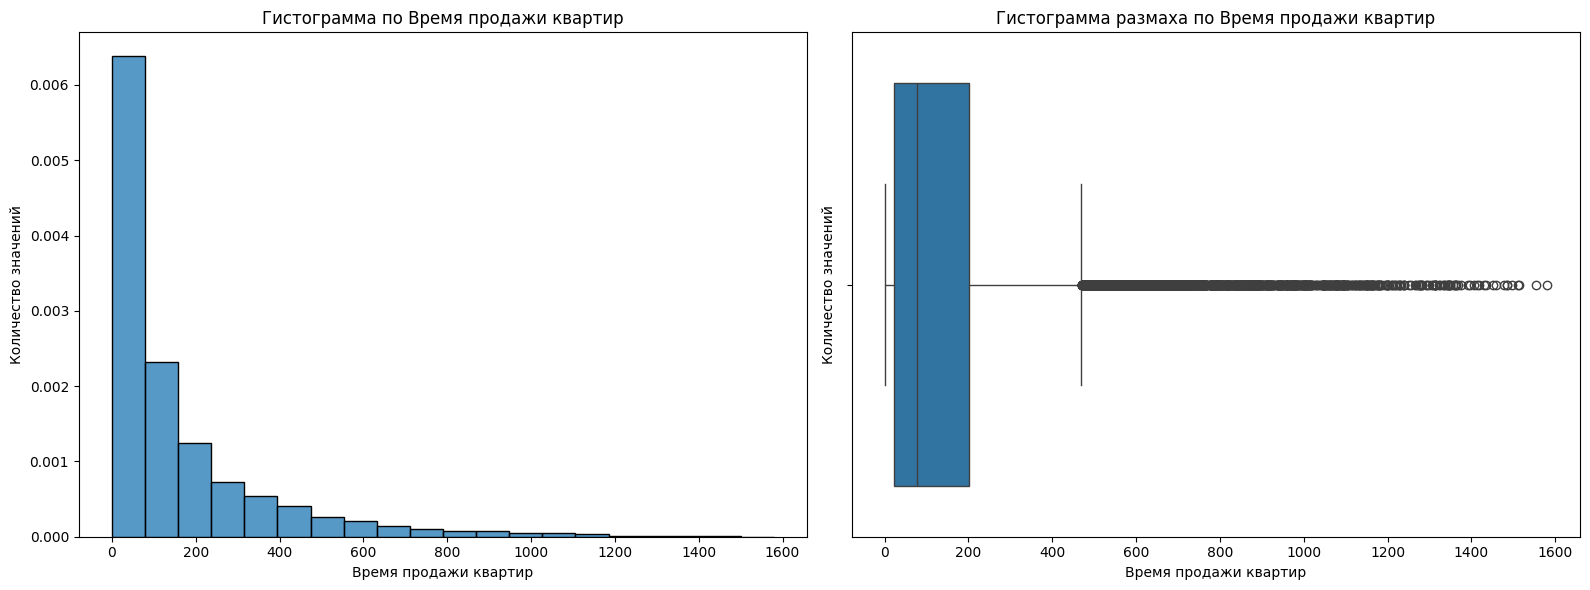

In [124]:
# Построим гистограмму по времени продажи квартир


num_diag(data, data['days_exposition'], 'Время продажи квартир', 'Количество значений')

In [125]:
# Посмотрим значения продаж квартир больше 1400

data[(data['days_exposition'] > 1400)]

total_images  last_price  total_area first_day_exposition  rooms  \
1885              2  13300000.0       79.60           2014-12-09      2   
2941              3  10090000.0       71.90           2015-02-02      2   
4736             11   6650000.0       68.30           2015-02-19      4   
6006              4   4400000.0       38.63           2015-02-03      1   
6691              3   4400000.0       42.98           2014-12-12      1   
6726              6  11995000.0       83.82           2014-11-27      2   
9553             11  10600000.0       80.00           2014-12-09      3   
9555             11   9950000.0       61.20           2015-04-06      2   
11955             4  11400000.0       76.00           2014-12-09      2   
11985             1  15104000.0      118.00           2015-05-19      3   
14093             7   9500000.0      100.00           2015-02-19      4   
14873             5   6400000.0       70.00           2015-02-19      4   
18843            11   3500000.0       48.20           2014-12-15      2   
19123             9   5990000.0       82.00           2015-02-19      3   
20996            10   3400000.0       54.60           2014-12-10      2   

       ceiling_height  floors_total  living_area  floor  is_apartment  studio  \
1885             3.00             8        42.70      7          True   False   
2941             2.65            10        34.10      9          True   False   
4736             2.63             5        45.10      4          True   False   
6006             2.85            25        15.00      6          True   False   
6691             2.65             5        18.72      1          True   False   
6726             2.73            11        42.31      1          True   False   
9553             2.85            17        44.00      9          True   False   
9555             3.17             7        39.70      2          True   False   
11955            2.65             9        36.00      3          True   False   
11985            3.10            16        64.32      5          True   False   
14093            3.00             5        76.00      5          True   False   
14873            3.10             5        56.70      3          True   False   
18843            2.50             5        27.40      2          True   False   
19123            3.00             4        60.00      2          True   False   
20996            2.50             5        29.70      1          True   False   

       open_plan  kitchen_area  balcony    locality_name  airports_nearest  \
1885       False         18.00        0  Санкт-Петербург           39393.0   
2941       False         16.80        2  Санкт-Петербург           23604.0   
4736       False          9.00        0  Санкт-Петербург           20182.0   
6006       False         12.30        2        Парголово           52611.0   
6691       False         11.31        0           Пушкин           19715.0   
6726       False         17.85        0  Санкт-Петербург           39946.0   
9553       False         15.00        0  Санкт-Петербург           17101.0   
9555       False          8.00        0  Санкт-Петербург            9740.0   
11955      False         14.00        0  Санкт-Петербург           39393.0   
11985      False         14.27        0  Санкт-Петербург           37434.0   
14093      False         10.00        0  Санкт-Петербург           25950.0   
14873      False          8.00        0  Санкт-Петербург           24451.0   
18843      False          7.70        3  Новое Девяткино           26726.0   
19123      False          8.00        0         Павловск           22465.0   
20996      False          8.50        2       Всеволожск           26726.0   

       city_centers_nearest  parks_around3000  parks_nearest  \
1885                11096.0                 1          537.0   
2941                 5294.0                 0            0.0   
4736                 1724.0                 3          606.0   
6006

In [126]:
# Проверим сколько из этих квартир не студии

data[(data['days_exposition'] > 1400) & (data['is_apartment'] == False)]

Empty DataFrame
Columns: [total_images, last_price, total_area, first_day_exposition, rooms, ceiling_height, floors_total, living_area, floor, is_apartment, studio, open_plan, kitchen_area, balcony, locality_name, airports_nearest, city_centers_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest, days_exposition, price_m, week_day, month, year, floor_type, city_centers_nearest_km]
Index: []

Возможно квартиры продавались так долго потому, что это апартаменты и довольно дорогие. За туже цену можно подыскать квартиру и не переплачивать за коммунальные услуги.

In [127]:
# Найдем среднее время продажи квартир

data['days_exposition'].mean()

157.63194206586093

In [128]:
# Найдем медиану времени продажи квартир

data['days_exposition'].median()

77.0

In [129]:
# Посчитаем значения квантилей

print(data['days_exposition'].quantile(0.25))
print(data['days_exposition'].quantile(0.75))

22.0
201.0


Можно считать значения дней продаж до 22 дней быстрыми, а больше 201 дней - долгими. Очень долгими думаю можно считать продажи квартир более 600 дней, количество продаж больше это времени почти нет.

#### Определение факторов, которые больше всего влияют на общую (полную) стоимость объекта

In [130]:
data.head()

total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0       108.0           2019-03-07      3   
1             7   3350000.0        40.4           2018-12-04      1   
2            10   5196000.0        56.0           2015-08-20      2   
5            10   2890000.0        30.4           2018-09-10      1   
6             6   3700000.0        37.3           2017-11-02      1   

   ceiling_height  floors_total  living_area  floor  is_apartment  studio  \
0            2.70            16         51.0      8          True   False   
1            2.65            11         18.6      1          True   False   
2            2.65             5         34.3      4          True   False   
5            2.65            12         14.4      5          True   False   
6            2.65            26         10.6      6          True   False   

   open_plan  kitchen_area  balcony    locality_name  airports_nearest  \
0      False          25.0        0  Санкт-Петербург           18863.0   
1      False          11.0        2           Шушары           12817.0   
2      False           8.3        0  Санкт-Петербург           21741.0   
5      False           9.1        0          Янино-1           26726.0   
6      False          14.4        1        Парголово           52996.0   

   city_centers_nearest  parks_around3000  parks_nearest  ponds_around3000  \
0               16028.0                 1          482.0                 2   
1               18603.0                 0            0.0                 0   
2               13933.0                 1           90.0                 2   
5               13095.0                 0            0.0                 0   
6               19143.0                 0            0.0                 0   

   ponds_nearest  days_exposition    price_m  week_day  month  year  \
0          755.0                0  120370.37         3      3  2019   
1            0.0               81   82920.79         1     12  2018   
2          574.0              558   92785.71         3      8  2015   
5            0.0               55   95065.79         0      9  2018   
6            0.0              155   99195.71         3     11  2017   

  floor_type  city_centers_nearest_km  
0     другой                       16  
1     первый                       19  
2     другой                       14  
5     другой                       13  
6     другой                       19

In [139]:
def scatter_plot(
    data: pd.DataFrame,
    x: str,
    y: str,
    hue: Optional[str] = None,
    alpha: float = 0.5,
    figsize: tuple = (8, 6),
    title: Optional[str] = None
) -> None:
    """
    Универсальная функция построения scatter-графиков.

    Поддерживает:
    - простой scatter (аналог data.plot(kind='scatter'))
    - scatter с hue (аналог sns.relplot)
    - прозрачность (alpha)
    - кастомный размер фигуры
    - заголовок

    Параметры
    ----------
    data : pd.DataFrame
        Таблица с данными.

    x : str
        Название признака по оси X.

    y : str
        Название признака по оси Y.

    hue : str, optional
        Категориальный признак для окрашивания точек.

    alpha : float, default=0.05
        Прозрачность точек.

    figsize : tuple, default=(8, 6)
        Размер графика.

    title : str, optional
        Заголовок графика.

    Возвращает
    ----------
    None
        Функция строит scatter-график.
    """
    plt.figure(figsize=figsize)

    sns.scatterplot(
        data=data,
        x=x,
        y=y,
        hue=hue,
        alpha=alpha,
        s=100
    )

    plt.xlabel(x)
    plt.ylabel(y)

    if title is not None:
        plt.title(title)
    else:
        plt.title(f"{y} ~ {x}")

    plt.tight_layout()
    plt.show()

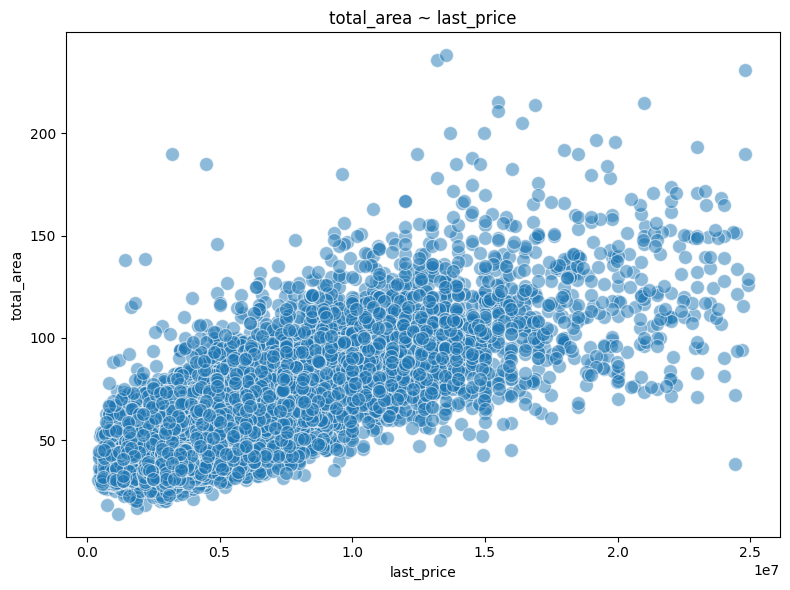

In [141]:
# Построим график зависимости общей площади от цены

scatter_plot(data, 'last_price', 'total_area')

1. Положительная корреляция: Наблюдается явная тенденция, где с увеличением цены растет и общая площадь. Это свидетельствует о положительной корреляции между этими двумя переменными.

3. Плотность точек: В нижней части графика (низкие цены) точки более плотно расположены, что может означать большое количество объектов с малой площадью по более низким ценам.

Можно сделать вывод о том, что цена недвижимости, по всей видимости, имеет прямую зависимость от общей площади объекта.

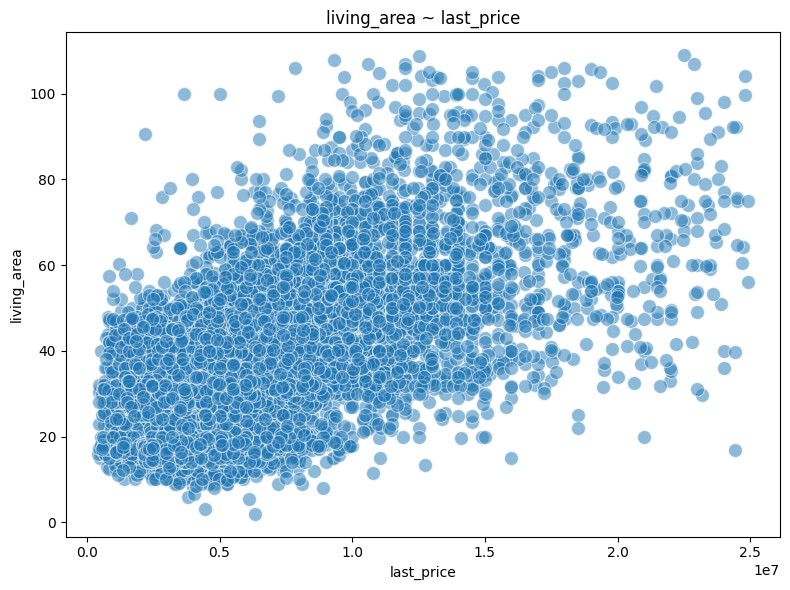

In [142]:
# Построим график зависимости жилой площади от цены

scatter_plot(data, 'last_price', 'living_area')

Распределение точек: Точки сгруппированы в виде 2х горизонтальных полос с диапазоном 15-25м и 25-35м, что может указывать на то, что жилые площади имеют в большинстве своем стандрартные значения.

Слабая корреляция: По графику сложно увидеть явную зависимость между ценой и жилой площадью. Это может говорить о том, что цена не сильно колеблется в зависимости от жилой площади.

Таким образом, можем сделать вывод, что жилая площадь не сильно влияет на цену недвижимости.

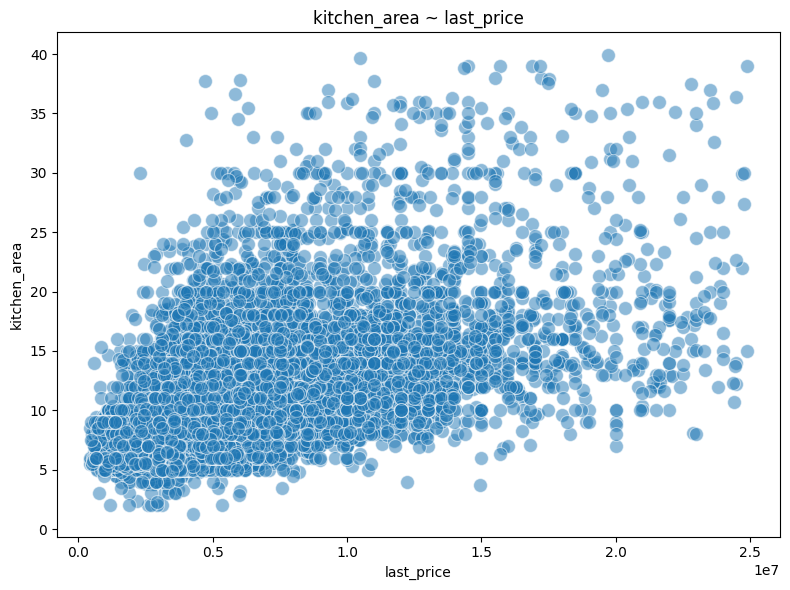

In [143]:
# Построим график зависимости общей площади от цены

scatter_plot(data, 'last_price', 'kitchen_area')

1. Распределение точек: Точки сгруппированы в виде нескольких горизонтальных полос, что может указывать на то, что площади кухонь в основном имеют ограниченный диапазон значений, независимо от цены. 

2. Слабая корреляция: По графику сложно увидеть явную зависимость между ценой и площадью кухни. Это может говорить о том, что цена не сильно колеблется в зависимости от размера кухни.

Таким образом, размеры кухонь не сильно влияют на цену недвижимости.

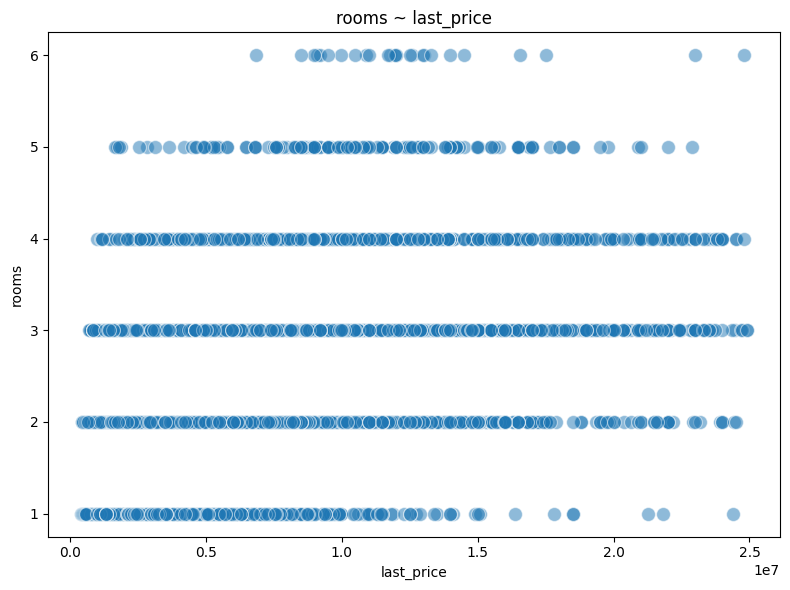

In [144]:
# Построим график зависимости количества комнат от цены

scatter_plot(data, 'last_price', 'rooms')

Слабая корреляция: По графику сложно увидеть явную зависимость между ценой и количеством комнат.

Таким образом, количество комнат не влияет на цену недвижимости, исключение составляют 1 комнатные квартиры - они восновоном в нижнем диапазоне цен.


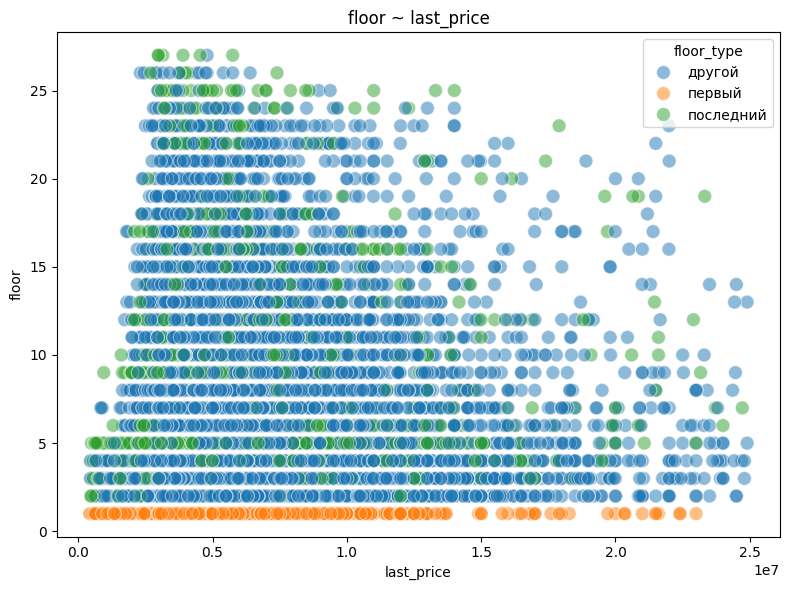

In [145]:
# Построим график зависисмоти этажа на котором расположена квартира от цены

scatter_plot(data, 'last_price', 'floor', hue='floor_type')

In [146]:
floor_type_price = data.pivot_table(index='floor_type', values='last_price', aggfunc='mean')
floor_type_price

last_price
floor_type              
другой      5.705693e+06
первый      4.399375e+06
последний   5.071331e+06

Слабая корреляция: По графику сложно увидеть явную зависимость между ценой и тем на каком этаже расположена квартира. В квартирах до 5го этажа мы можем встретить квартиру во всем диапазоне цен, с увеличением этажа минимальная цена немного растет, но расброс цен также большой.

Таким образом, этаж квартиры не влияет на цену недвижимости, с замечанием что после 5го этажа минимальная цена немного вырастает.

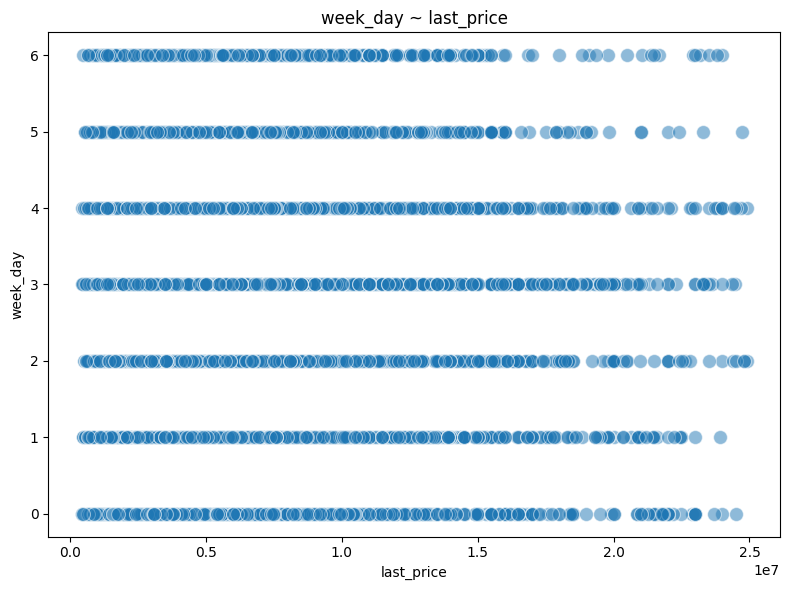

In [147]:
# Зависимость дня недели размещения обьявления от цены

scatter_plot(data, 'last_price', 'week_day')

In [148]:
data['week_day'].value_counts()

week_day
3    3677
1    3645
4    3463
2    3424
0    3148
5    1644
6    1436
Name: count, dtype: int64

Отсутствие корреляции: По графику корреляция между днем размещения объявления и ценой корреляция отсутствует. Если подсчитать уникальные значения, то можно сделать вывод, что люди размещают объяления восновном в будни, а выходные делают это ппочти в 2 раза реже. Однако на цену это никак не влияет.

Таким образом, цена никак не связа с днем недели когда разместили объявление.

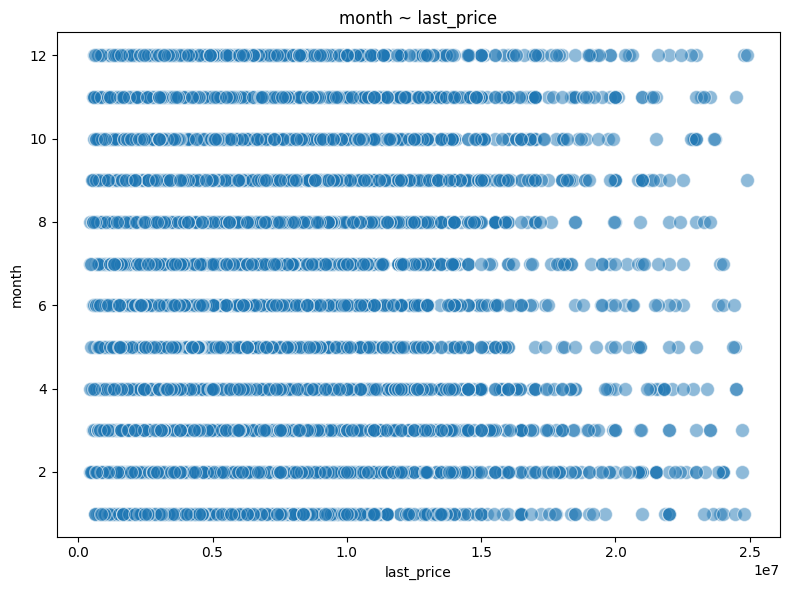

In [149]:
# Зависимость месяца размещения обьявления от цены

scatter_plot(data, 'last_price', 'month')

In [150]:
data['month'].value_counts().sort_values()

month
5     1103
1     1234
12    1303
7     1428
8     1519
6     1537
9     1773
10    1891
11    2097
4     2102
3     2219
2     2231
Name: count, dtype: int64

Отсутствие корреляции: По графику корреляции между месяцем размещения объявления и ценой корреляция отсутствует. 
Таким образом, цена никак не связа с месяцем когда разместили объявление.

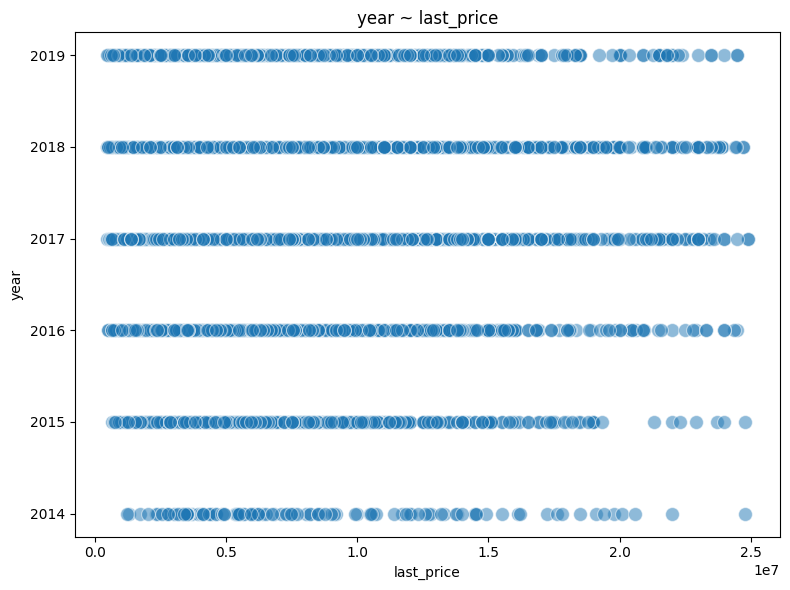

In [151]:
# Зависимость года размещения обьявления от цены

scatter_plot(data, 'last_price', 'year')

In [152]:
data['year'].value_counts().sort_values()

year
2014     112
2015     999
2016    2437
2019    2552
2017    7126
2018    7211
Name: count, dtype: int64

Отсутствие корреляции: По графику корреляции между годом размещения объявления и ценой корреляци отсутствует. Можно отметить что объявлений за 2014 год почти нет в выборке, больше всего разместили объявлений 2017-2018 годах, на цену это никак не влияет. 
Таким образом, цена никак не связа с месяцем когда разместили объявление.

#### Рассчет средней цены одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений 

In [153]:
# Построим сводную таблицу для 10 населенных пунктов сгруппированных по количеству объявлений и средней цене на 1 кв м

data.pivot_table(index='locality_name', values=['price_m'], aggfunc=['count', 'mean']).sort_values(by=('count','price_m'), ascending=False).head(10)

count           mean
                price_m        price_m
locality_name                         
Санкт-Петербург   13435  108818.839620
Мурино              479   85613.453925
Шушары              396   78556.807904
Кудрово             388   95321.532887
Всеволожск          354   69041.211469
Колпино             321   75129.845452
Пушкин              320  102103.078063
Гатчина             293   68748.605939
Парголово           289   90691.341972
Выборг              190   57916.628789

Санкт-Петербург ожидаемо имеет самую высокую цену за кв м и больше всего объявлений о продаже квартир, меньше всего цена за кв м в Выборге.

#### Рассчет средней стоимости квартир в зависимости от удаленности от центра в Санкт-Петербурге

In [154]:
spb_center_nearest_price = data[data['locality_name'] == 'Санкт-Петербург'].pivot_table(index=['city_centers_nearest_km'], values='last_price', aggfunc='mean')
spb_center_nearest_price

last_price
city_centers_nearest_km              
0                        9.084286e+06
1                        1.040250e+07
2                        1.018605e+07
3                        8.849442e+06
4                        9.290610e+06
5                        9.657517e+06
6                        8.528447e+06
7                        8.281911e+06
8                        8.523504e+06
9                        6.520525e+06
10                       6.162025e+06
11                       5.963416e+06
12                       5.871822e+06
13                       5.960793e+06
14                       5.522617e+06
15                       5.694698e+06
16                       5.323310e+06
17                       5.232620e+06
18                       4.954035e+06
19                       5.093689e+06
20                       4.611579e+06
21                       5.378074e+06
22                       5.345388e+06
23                       4.707233e+06
24                       3.944083e+06
25                       4.491176e+06
26                       4.021500e+06
27                       8.300000e+06
28                       5.026429e+06
29                       4.640000e+06

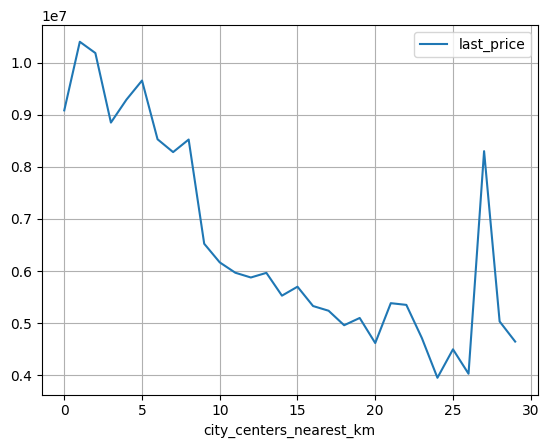

In [155]:
# Построим график зависимости цены квартиры в зависимости от ее удаленности от центра в Санкт-Петербурге

spb_center_nearest_price.plot(grid=True)
plt.show()

По графику можно сделать вывод - чем дальше квартира от центра тем она в среднем дешевле.

### Общий вывод

В данной проекте мы провели следующую работу:
- Заполнили пропущенные значения
- Удалили неявные дубликаты
- Преобразоцвали типы данных в подходящие
- Изучили параметры квартир, построили гистограммы и диаграммы размаха
- Удалили выбросы, восстановили данные по высоте потолков
- Определили факторы которые больше всего влияют на стоимость квартир
- Выявили населенные пункты с наибольшей и наименьшей цено за кв м
- Рассчитали стоимость квартир в зависимости от удаленности от центра в Санкт-Петербурге

При изучении параметров квартир было отмечено:
1. Общая площадь квартир находится в диапазоне от 12 до 114, 43 кв м самые популярные квартиры по площади.
2. По жилой площади самые популярные это квартиры 18 и 30 кв м что соответсвует 1 и 2х комнатным квартирам.
3. Самая популярная по площади кухня - 11 кв м
4. Самые часто размещаемые квартиры по цене около 4 млн
5. По количеству комнат самые популярные квартиры 1 и 2х комнатные
6. Самая распространенная высота потолков 2.65 м
7. Основная масса квартир в объявлениях находится между первым и последним этажом
8. Этажность домов преобладающих в объявлениях это 5 и 9 этажей
9. Основная масса квартир находится в 10-17 км от центра города
10. Большинство квартир имеют на расстоянии 250-650м парки

Ключевые результаты и выводы:
1. Цена квартиры зависит от общей площади, чем больше площадь, тем выше цена квартиры.
2. Жилая площадь, площадь кухни, этаж квартиры почти никак не коррелирует с ценой
3. День недели, месяц и год рамещения объявления также не влияет на стоимость
4. Самая дорогая за 1 кв м недвижимость находится в Санкт-Петербурге, самая дешевая - в Выборге.
5. Чем ближе к центру Санкт-Петербурга тем цена на квартиру выше.

Используя полученные данные мы сможем точнее прогнозировать цену на новые квартиры в Санкт-Петербурге и области.